In [2]:
import pandas as pd
import numpy as np
from numpy import hstack, array
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima import auto_arima, ARIMA
from arch import arch_model


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape


import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from math import sqrt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense, Masking, LSTM



In [5]:
btc = yf.Ticker("BTC-USD")
btc_history = btc.history(period = "max", end='2024-05-25')
#history = btc.history(start='2022-05-18', end='2024-04-30', interval = '1h')
btc_history = btc_history.drop(["Dividends", "Stock Splits"], axis = 1) # удаляю Dividends и Stock Splits так как они пустые (у криптовалюты нет дивидендов)
btc_history

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...
2024-05-20 00:00:00+00:00,66278.742188,71483.562500,66086.171875,71448.195312,43850655717
2024-05-21 00:00:00+00:00,71443.062500,71946.460938,69191.125000,70136.531250,46932005990
2024-05-22 00:00:00+00:00,70135.320312,70623.695312,68977.695312,69122.335938,32802561717


In [6]:
df = btc_history["Close"]

In [7]:
#dataframe = pd.DataFrame({'Date':df.index, 'Close':df.values})

In [8]:
df.head(), df.tail(), df.shape

(Date
 2014-09-17 00:00:00+00:00    457.334015
 2014-09-18 00:00:00+00:00    424.440002
 2014-09-19 00:00:00+00:00    394.795990
 2014-09-20 00:00:00+00:00    408.903992
 2014-09-21 00:00:00+00:00    398.821014
 Name: Close, dtype: float64,
 Date
 2024-05-20 00:00:00+00:00    71448.195312
 2024-05-21 00:00:00+00:00    70136.531250
 2024-05-22 00:00:00+00:00    69122.335938
 2024-05-23 00:00:00+00:00    67929.562500
 2024-05-24 00:00:00+00:00    68526.101562
 Name: Close, dtype: float64,
 (3538,))

<Axes: xlabel='Date'>

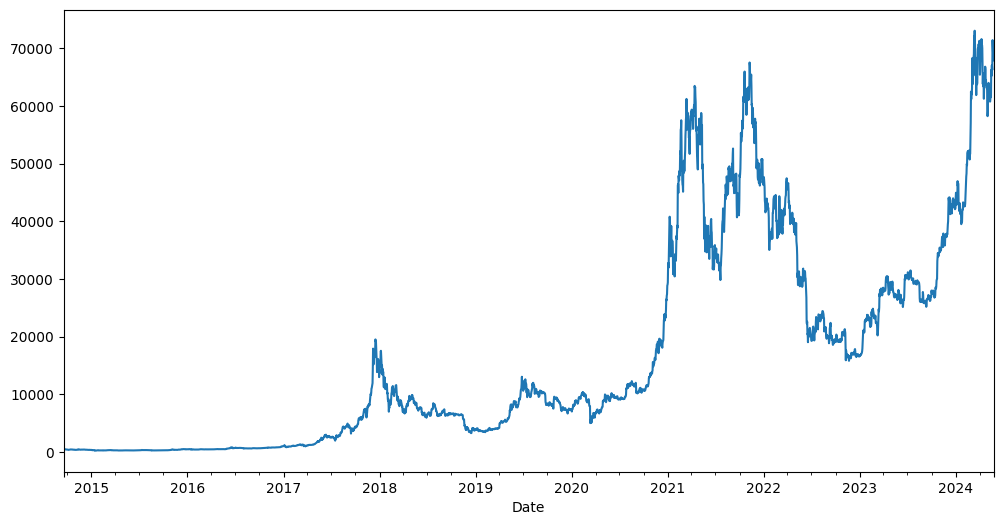

In [9]:
df.plot(figsize=(12,6))

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
     

In [11]:
btc_history.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

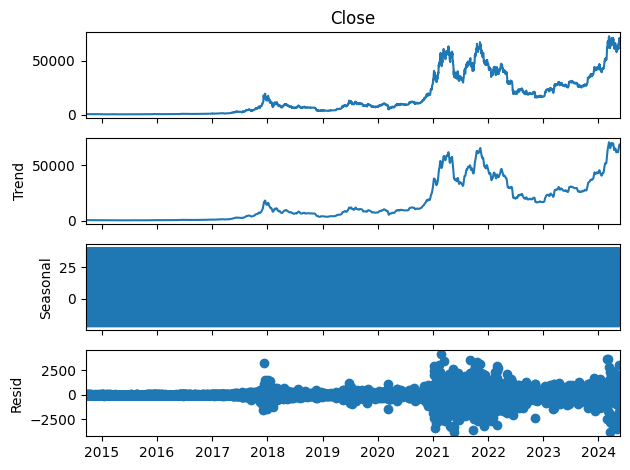

In [12]:
results = seasonal_decompose(btc_history['Close'])
results.plot();

Проверим данные на стационарность используя тест Дики-Фуллера

In [13]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)


In [14]:
ad_test(df)  # p-value > 0.05; Data is not stationary

1. ADF :  -0.62580115009061
2. P-Value :  0.8650448040466583
3. Num Of Lags :  28
4. Num Of Observations Used For ADF Regression: 3509
5. Critical Values :
	 1% :  -3.4322149444714065
	 5% :  -2.8623640267493293
	 10% :  -2.567208643634359


In [15]:
ad_test(btc_history['Volume']) # только Volume стационарный среди параметров в History

1. ADF :  -2.3517741760761948
2. P-Value :  0.15581274212539103
3. Num Of Lags :  29
4. Num Of Observations Used For ADF Regression: 3508
5. Critical Values :
	 1% :  -3.4322154764873143
	 5% :  -2.8623642617472096
	 10% :  -2.5672087687403544


# Попробуем избавиться от стационарности

In [16]:
df['биткоин_без_тренда'] = df - df.rolling(window=2).mean() # убираем среднее в окне между двумя значениями

C:\Users\User\AppData\Local\Temp\ipykernel_22260\3030915947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['биткоин_без_тренда'] = df - df.rolling(window=2).mean() # убираем среднее в окне между двумя значениями


In [17]:
df['биткоин_без_тренда_и_сезонности'] = df['биткоин_без_тренда'].diff() #Преобразование для удаления сезонности (в данном случае просто разница между текущим и предыдущим значением)

In [18]:
# появилось NA значение 
print(df['биткоин_без_тренда_и_сезонности'].isnull().sum().sum ())
# появилось NA значение 
print(df['биткоин_без_тренда'].isnull().sum().sum ())

2
1


In [19]:
df['биткоин_без_тренда_и_сезонности'].dropna(inplace=True) # Удалим первые строки с пропущенными значениями
df['биткоин_без_тренда'].dropna(inplace=True) # Удалим первые строки с пропущенными значениями

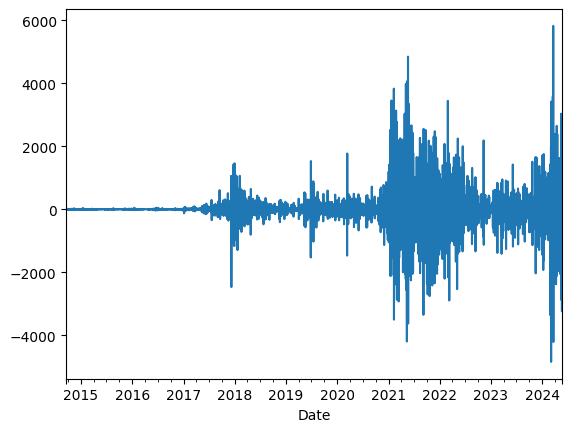

In [20]:
df['биткоин_без_тренда_и_сезонности'].plot();

In [21]:
ad_test(df['биткоин_без_тренда_и_сезонности'])  # p-value < 0.05; Data is stationary.  pv = 1.9341189930150036e-15 - для биткоин_без_тренда  > 2.235617394452057e-30 - для биткоин_без_тренда_и_сезонности (вывод оба ряда стационарны, но без сезонности с еще большей точностью)

1. ADF :  -18.48466270150043
2. P-Value :  2.1308733500292354e-30
3. Num Of Lags :  30
4. Num Of Observations Used For ADF Regression: 3505
5. Critical Values :
	 1% :  -3.432217074357827
	 5% :  -2.8623649675457465
	 10% :  -2.5672091444868856


# ARIMA

In [19]:
from pmdarima import auto_arima


Попробуем подобрать модель ARIMA на трех полученных df. (не стационарном, стационарном - биткоин_без_тренда, стационарном - биткоин_без_тренда_и_сезонности)
И сравним их по показателю AIC

Обучать будем на треин датасете (все имеющиеся данные без последних 30 дней)

In [20]:
print(df.shape)
train= btc_history["Close"].iloc[:-30]
test = btc_history["Close"].iloc[-30:]
print(train.shape, test.shape)

(3540,)
(3508,) (30,)


In [21]:
print(df['биткоин_без_тренда'].shape)
train_no_trend=df['биткоин_без_тренда'].iloc[:-30]
test_no_trend=df['биткоин_без_тренда'].iloc[-30:]
print(train_no_trend.shape,test_no_trend.shape)

(3537,)
(3507,) (30,)


In [22]:
print(df['биткоин_без_тренда_и_сезонности'].shape)
train_no_trend_no_s = df['биткоин_без_тренда_и_сезонности'].iloc[:-30]
test_no_trend_no_s = df['биткоин_без_тренда_и_сезонности'].iloc[-30:]
print(train_no_trend.shape,test_no_trend.shape)

(3536,)
(3507,) (30,)


Some Trials, you can skip them to best models

Ищем лучшую ARIMA / SARIMA модель среди отобранных датасетов

In [23]:
ARIMA_MODEL_1 = auto_arima(train, suppress_warnings=True) #, trace=True) #  ARIMA(4,1,2)(0,0,0)[0]  AIC=57162.824

In [24]:
ARIMA_MODEL_1.summary() #  ARIMA(4,1,2)(0,0,0)[0]  AIC=57162.824

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3508
Model:               SARIMAX(4, 1, 2)   Log Likelihood              -28574.412
Date:                Thu, 06 Jun 2024   AIC                          57162.824
Time:                        08:16:45   BIC                          57205.962
Sample:                    09-17-2014   HQIC                         57178.218
                         - 04-24-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7919      0.013     61.133      0.000       0.766       0.817
ar.L2         -0.8945      0.014    -62.470      0.000      -0.923      -0.866
ar.L3         -0.0465      0.012     -3.945      0.000      -0.070      -0.023
ar.L4          0.0304      0.009      3.365      0.001       0.013       0.048
ma.L1         -0.8447      0.010    -80.711      0.000      -0.865      -0.824
ma.L2          0.9547      0.010     95.095      0.000       0.935       0.974
sigma2       7.04e+05   6046.766    116.418      0.000    6.92e+05    7.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             30060.42
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             228.38   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
ARIMA_MODEL_1_S = auto_arima(train, suppress_warnings=True,  m=12, seasonal=True, trace=True)  #  ARIMA(4,1,2)(0,0,0)[0]  AIC=57162.824

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=57134.714, Time=3.85 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=57186.771, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=57173.430, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=57174.558, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=57186.415, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=57156.412, Time=2.89 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=57154.477, Time=3.52 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=57133.661, Time=10.12 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=57143.726, Time=9.44 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=57124.381, Time=16.52 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=57133.285, Time=11.36 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=12.78 sec
 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=12.15 sec
 ARIMA(3,1,2)(2,0,2)[12] intercept   : AIC=57134.702, Time=17.04 sec
 ARIMA(2,1,

In [26]:
ARIMA_MODEL_1_S.summary() #  SARIMA(2, 1, 3)x(2, 0, [1, 2], 12)  AIC=57121.010

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 3508
Model:             SARIMAX(2, 1, 3)x(2, 0, [1, 2], 12)   Log Likelihood              -28550.505
Date:                                 Thu, 06 Jun 2024   AIC                          57121.010
Time:                                         08:23:48   BIC                          57182.635
Sample:                                     09-17-2014   HQIC                         57143.001
                                          - 04-24-2024                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3684      0.011    125.938      0.000       1.347       1.390
ar.L2         -0.9367      0.010    -97.371      0.000      -0.956      -0.918
ma.L1         -1.4168      0.013   -105.637      0.000      -1.443      -1.391
ma.L2          1.0221      0.015     67.208      0.000       0.992       1.052
ma.L3         -0.0387      0.009     -4.253      0.000      -0.057      -0.021
ar.S.L12      -1.5267      0.087    -17.545      0.000      -1.697      -1.356
ar.S.L24      -0.7034      0.069    -10.184      0.000      -0.839      -0.568
ma.S.L12       1.4723      0.085     17.236      0.000       1.305       1.640
ma.S.L24       0.6885      0.062     11.188      0.000       0.568       0.809
sigma2       7.05e+05   6292.423    112.039      0.000    6.93e+05    7.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             28233.96
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):             231.65   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Посмотрим на лучшую модель для датасета без тренда

In [27]:
ARIMA_MODEL_2 = auto_arima(train_no_trend, suppress_warnings=True) #  ARIMA(4,0,2)(0,0,0)[0]  AIC=52301.081

In [28]:
ARIMA_MODEL_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3507
Model:               SARIMAX(4, 0, 2)   Log Likelihood              -26143.541
Date:                Thu, 06 Jun 2024   AIC                          52301.081
Time:                        08:24:07   BIC                          52344.219
Sample:                    09-18-2014   HQIC                         52316.475
                         - 04-24-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7915      0.013     60.755      0.000       0.766       0.817
ar.L2         -0.8944      0.014    -62.226      0.000      -0.923      -0.866
ar.L3         -0.0465      0.012     -3.947      0.000      -0.070      -0.023
ar.L4          0.0306      0.009      3.386      0.001       0.013       0.048
ma.L1         -0.8442      0.011    -79.925      0.000      -0.865      -0.823
ma.L2          0.9543      0.010     94.116      0.000       0.934       0.974
sigma2      1.759e+05   1510.327    116.471      0.000    1.73e+05    1.79e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             30071.32
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):             228.37   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

добавим сезонность

In [29]:
ARIMA_MODEL_2_S = auto_arima(train_no_trend, suppress_warnings=True,  m=12, seasonal=True, trace=True) #  SARIMA(2, 0, 3)x(2, 0, [1, 2], 12)  AIC=52259.317 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=52272.970, Time=3.91 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=52325.036, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=52311.699, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=52312.827, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=52324.681, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=52294.641, Time=3.43 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=52292.719, Time=2.97 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=52271.909, Time=9.51 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=52281.948, Time=9.25 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=52262.903, Time=17.24 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=52271.528, Time=11.46 sec
 ARIMA(1,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=13.53 sec
 ARIMA(2,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=10.51 sec
 ARIMA(3,0,2)(2,0,2)[12] intercept   : AIC=52272.768, Time=19.56 sec
 ARIMA(2,0,3

In [30]:
ARIMA_MODEL_2_S.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 3507
Model:             SARIMAX(2, 0, 3)x(2, 0, [1, 2], 12)   Log Likelihood              -26119.658
Date:                                 Thu, 06 Jun 2024   AIC                          52259.317
Time:                                         08:30:37   BIC                          52320.942
Sample:                                     09-18-2014   HQIC                         52281.308
                                          - 04-24-2024                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3709      0.011    126.764      0.000       1.350       1.392
ar.L2         -0.9388      0.010    -97.872      0.000      -0.958      -0.920
ma.L1         -1.4172      0.013   -106.097      0.000      -1.443      -1.391
ma.L2          1.0214      0.015     67.494      0.000       0.992       1.051
ma.L3         -0.0376      0.009     -4.141      0.000      -0.055      -0.020
ar.S.L12      -1.5319      0.086    -17.784      0.000      -1.701      -1.363
ar.S.L24      -0.7022      0.069    -10.178      0.000      -0.837      -0.567
ma.S.L12       1.4766      0.085     17.464      0.000       1.311       1.642
ma.S.L24       0.6870      0.061     11.204      0.000       0.567       0.807
sigma2      1.761e+05   1571.346    112.098      0.000    1.73e+05    1.79e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             28210.45
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):             231.54   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
ARIMA_MODEL_3 = auto_arima(train_no_trend_no_s, suppress_warnings=True) #  ARIMA(5,0,0)(0,0,0)[0]  AIC=52796.708

In [32]:
ARIMA_MODEL_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3506
Model:               SARIMAX(5, 0, 0)   Log Likelihood              -26392.354
Date:                Thu, 06 Jun 2024   AIC                          52796.708
Time:                        08:30:45   BIC                          52833.681
Sample:                    09-19-2014   HQIC                         52809.902
                         - 04-24-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8996      0.008   -116.688      0.000      -0.915      -0.884
ar.L2         -0.7271      0.011    -66.889      0.000      -0.748      -0.706
ar.L3         -0.5241      0.012    -42.808      0.000      -0.548      -0.500
ar.L4         -0.3187      0.012    -27.319      0.000      -0.342      -0.296
ar.L5         -0.1519      0.008    -18.379      0.000      -0.168      -0.136
sigma2      2.026e+05   1777.176    113.976      0.000    1.99e+05    2.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.08   Jarque-Bera (JB):             26932.58
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):             238.86   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

к этой модели сезонность добавлять не логично, так как мы ее уничтожили в ходе преобразования исходного датафрейма

# Модель с датасетом "биткоин_без_тренда" оказалась лучшей по AIC 

In [33]:
ARIMA_MODEL_2_S = auto_arima(train_no_trend, suppress_warnings=True,  m=12, seasonal=True, trace=True) # лучшая по AIC

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=52272.970, Time=3.89 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=52325.036, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=52311.699, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=52312.827, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=52324.681, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=52294.641, Time=3.39 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=52292.719, Time=2.97 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=52271.909, Time=9.41 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=52281.948, Time=9.19 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=52262.903, Time=17.35 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=52271.528, Time=11.79 sec
 ARIMA(1,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=14.18 sec
 ARIMA(2,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=10.59 sec
 ARIMA(3,0,2)(2,0,2)[12] intercept   : AIC=52272.768, Time=19.99 sec
 ARIMA(2,0,3

предскажем на 30 дней вперед (по 1 дню с добавлением нового значения)

In [34]:
def forecast_one_step_1():
    fc, conf_int = ARIMA_MODEL_2_S.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

In [35]:
forecasts = []
confidence_intervals = []

for new_ob in test_no_trend:
    fc, conf = forecast_one_step_1()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    ARIMA_MODEL_2_S.update(new_ob)

rmse=sqrt(mean_squared_error(forecasts,test_no_trend))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_no_trend, forecasts)}") 
print(f"SMAPE: {smape(test_no_trend, forecasts)}")

# Root Mean squared error: 969.9832300780425
# Mean squared error: 940867.4666326328
# SMAPE: 173.24732617648633

Root Mean squared error: 969.9832300780425
Mean squared error: 940867.4666326328
SMAPE: 173.24732617648633


Но она предсказывает значения которые еще нужно перевести обратно с трендом

поэтому 


## Попробуем модель работающую сразу с трендом для предсказния сразу на 30 периодов

In [36]:
ARIMA_MODEL_1_S_pred_1 = auto_arima(train, suppress_warnings=True,  m=12, seasonal=True, trace=True, max_p = 30, max_q = 30) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=57134.714, Time=4.15 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=57186.771, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=57173.430, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=57174.558, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=57186.415, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=57156.412, Time=3.08 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=57154.477, Time=3.77 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=57133.661, Time=11.09 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=57143.726, Time=10.15 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=57124.381, Time=18.22 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=57133.285, Time=12.42 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=13.39 sec
 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=12.98 sec
 ARIMA(3,1,2)(2,0,2)[12] intercept   : AIC=57134.702, Time=17.54 sec
 ARIMA(2,1

In [37]:
fc = ARIMA_MODEL_1_S_pred_1.predict(n_periods=30, )
rmse=sqrt(mean_squared_error(fc,test))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test, fc)}") 
print(f"SMAPE: {smape(test, fc)}")

Root Mean squared error: 3179.041057736404
Mean squared error: 10106302.046773795
SMAPE: 3.6834072634822808


In [38]:
test_df_fc = test.to_frame()
test_df_fc['SARIMA Forecast 30 days'] = fc
test_df_fc

,Close,SARIMA Forecast 30 days
Date,,
2024-04-25 00:00:00+00:00,64481.707031,64320.387170
2024-04-26 00:00:00+00:00,63755.320312,63974.979630
2024-04-27 00:00:00+00:00,63419.140625,64068.210563
2024-04-28 00:00:00+00:00,63113.230469,64025.067095
2024-04-29 00:00:00+00:00,63841.121094,63767.769290
2024-04-30 00:00:00+00:00,60636.855469,63635.896516
2024-05-01 00:00:00+00:00,58254.011719,63702.314895
2024-05-02 00:00:00+00:00,59123.433594,63933.686787
2024-05-03 00:00:00+00:00,62889.835938,63532.319176


<Axes: xlabel='Date'>

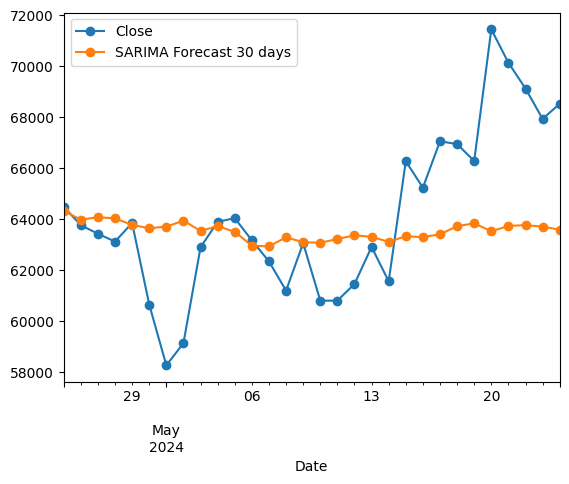

In [39]:
test_df_fc.plot(marker='o', label = True)

In [40]:
def forecast_one_step_1():
    fc, conf_int = ARIMA_MODEL_1_S_pred_1.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

In [41]:
forecasts = []
confidence_intervals = []

for new_ob in test:
    fc, conf = forecast_one_step_1()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    ARIMA_MODEL_1_S_pred_1.update(new_ob)

rmse=sqrt(mean_squared_error(forecasts,test))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test, forecasts)}") 
print(f"SMAPE: {smape(test, forecasts)}")

# Root Mean squared error: 1940.9687672379732
# Mean squared error: 3767359.755393298
# SMAPE: 2.228641361828634

Root Mean squared error: 1940.9687672379732
Mean squared error: 3767359.755393298
SMAPE: 2.228641361828634


In [42]:
test_df = test.to_frame()
test_df['SARIMAForecast'] = forecasts
test_df

,Close,SARIMAForecast
Date,,
2024-04-25 00:00:00+00:00,64481.707031,64320.387170
2024-04-26 00:00:00+00:00,63755.320312,64127.567834
2024-04-27 00:00:00+00:00,63419.140625,63870.854313
2024-04-28 00:00:00+00:00,63113.230469,63395.964638
2024-04-29 00:00:00+00:00,63841.121094,62851.955290
2024-04-30 00:00:00+00:00,60636.855469,63634.615468
2024-05-01 00:00:00+00:00,58254.011719,60841.193966
2024-05-02 00:00:00+00:00,59123.433594,58574.865596
2024-05-03 00:00:00+00:00,62889.835938,58583.799825


<Axes: xlabel='Date'>

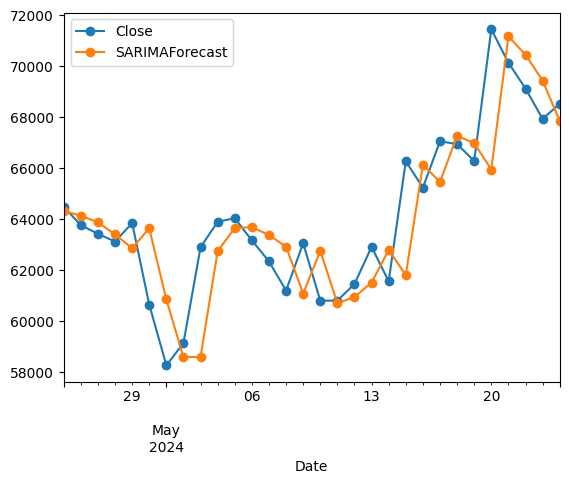

In [43]:
test_df.plot(marker='o', label = True)

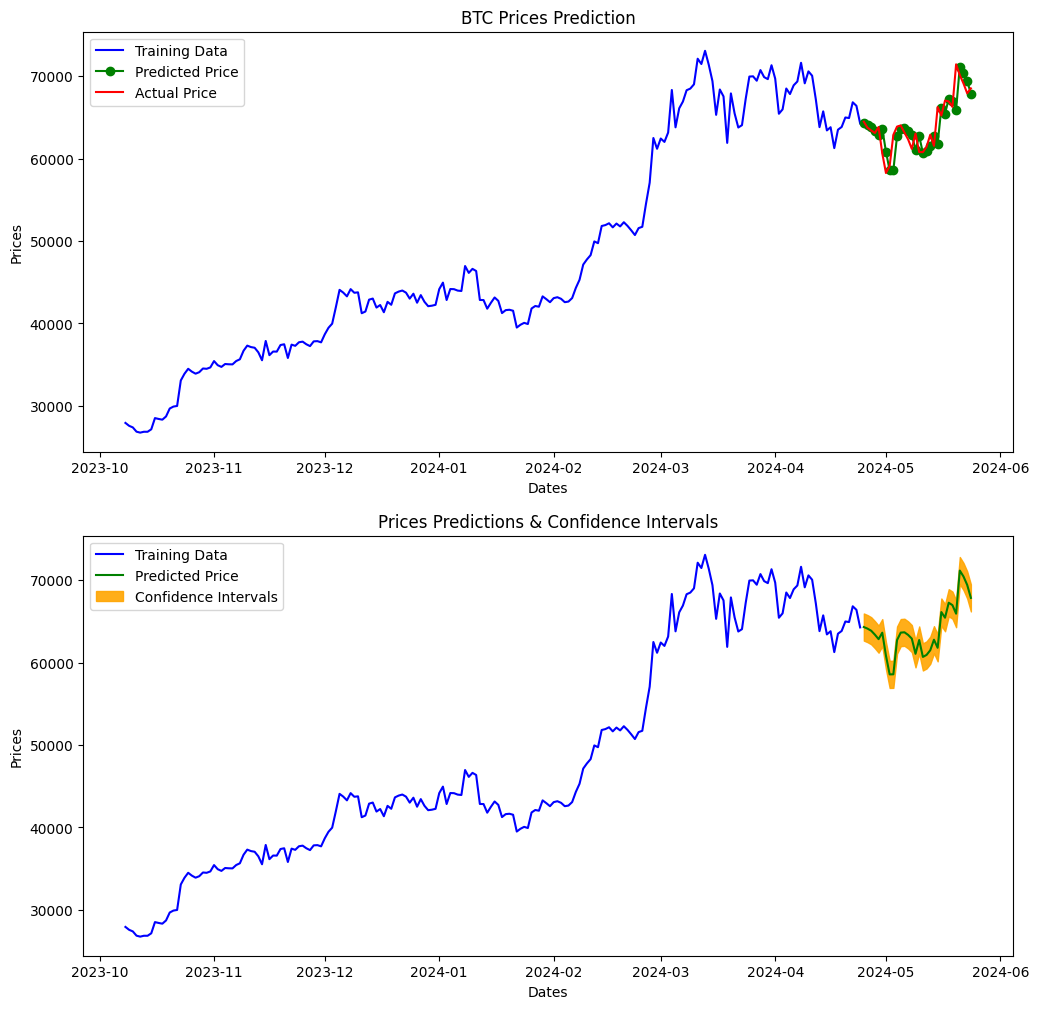

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(train[-200:], color='blue', label='Training Data')
axes[0].plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test.index, test, color='red', label='Actual Price')
axes[0].set_title('BTC Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')


axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(train[-200:], color='blue', label='Training Data')
axes[1].plot(test.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")


axes[1].legend()

## Попробую добавить ARCH, GARCH к ARIMA (временно игнор)

In [45]:
ARIMA_MODEL_1_S = auto_arima(train, suppress_warnings=True,  m=12, seasonal=True, trace=True) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=57134.714, Time=3.74 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=57186.771, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=57173.430, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=57174.558, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=57186.415, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=57156.412, Time=3.02 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=57154.477, Time=3.43 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=57133.661, Time=10.41 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=57143.726, Time=9.51 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=57124.381, Time=16.62 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=57133.285, Time=11.50 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=12.82 sec
 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=12.23 sec
 ARIMA(3,1,2)(2,0,2)[12] intercept   : AIC=57134.702, Time=17.53 sec
 ARIMA(2,1,

In [46]:
residuals = ARIMA_MODEL_1_S.resid() # остатки train

In [47]:
residuals

Date
2014-09-17 00:00:00+00:00     457.334015
2014-09-18 00:00:00+00:00     -24.118898
2014-09-19 00:00:00+00:00     -34.089967
2014-09-20 00:00:00+00:00       7.531220
2014-09-21 00:00:00+00:00     -12.811656
                                ...     
2024-04-20 00:00:00+00:00    1302.755886
2024-04-21 00:00:00+00:00    -642.186290
2024-04-22 00:00:00+00:00    2295.470018
2024-04-23 00:00:00+00:00    -598.941869
2024-04-24 00:00:00+00:00   -2896.748553
Length: 3508, dtype: float64

In [48]:
from statsmodels.stats.diagnostic import het_arch


In [49]:
arch_test = het_arch(residuals)
arch_test

(545.0413952504823,
 1.0316903214473817e-110,
 64.36119159210647,
 1.2814185213638743e-120)

1.0316903214473817e-110 < 0.05 в остатках присутствует гетероскедастичность

функция определяет лучший GARCH, но на практике обычно используют 1, 1

In [50]:
def find_best_garch_model(residuals, p_range, q_range):
    best_aic = np.inf
    best_order = None
    best_model = None

    for p, q in itertools.product(p_range, q_range):
        try:
            model = arch_model(residuals, vol='Garch', p=p, q=q)
            result = model.fit(disp='off')
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = (p, q)
                best_model = result
        except Exception as e:
            print(f"Model fitting failed for (p, q)=({p}, {q}): {e}")
            continue

    return best_order, best_model

# Диапазоны значений p и q для перебора
p_range = range(1, 5)
q_range = range(1, 5)

# Поиск лучших параметров GARCH
best_order, best_garch_model = find_best_garch_model(residuals, p_range, q_range)

print(f"Best GARCH order: {best_order}")
print(best_garch_model.summary())


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.89e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The sc

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.89e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The sc

Best GARCH order: (2, 4)
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -23704.4
Distribution:                  Normal   AIC:                           47424.8
Method:            Maximum Likelihood   BIC:                           47474.1
                                        No. Observations:                 3508
Date:                Thu, Jun 06 2024   Df Residuals:                     3507
Time:                        08:55:10   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2574      0.311      0.828  

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.89e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [51]:
residuals[-60:-30]

Date
2024-02-25 00:00:00+00:00     112.935571
2024-02-26 00:00:00+00:00    2937.767545
2024-02-27 00:00:00+00:00    2482.556939
2024-02-28 00:00:00+00:00    5457.765064
2024-02-29 00:00:00+00:00   -1124.734255
2024-03-01 00:00:00+00:00     917.870090
2024-03-02 00:00:00+00:00    -536.350050
2024-03-03 00:00:00+00:00    1036.604946
2024-03-04 00:00:00+00:00    5251.997211
2024-03-05 00:00:00+00:00   -4028.140807
2024-03-06 00:00:00+00:00    2117.754654
2024-03-07 00:00:00+00:00     725.468990
2024-03-08 00:00:00+00:00    1359.724806
2024-03-09 00:00:00+00:00      71.202149
2024-03-10 00:00:00+00:00     683.366485
2024-03-11 00:00:00+00:00    3372.187785
2024-03-12 00:00:00+00:00    -480.496695
2024-03-13 00:00:00+00:00    1727.694966
2024-03-14 00:00:00+00:00   -1617.290729
2024-03-15 00:00:00+00:00   -2146.109469
2024-03-16 00:00:00+00:00   -3940.048101
2024-03-17 00:00:00+00:00    2635.516579
2024-03-18 00:00:00+00:00    -333.749847
2024-03-19 00:00:00+00:00   -5281.328048
2024-03-20 

In [52]:
residuals[-3:]

Date
2024-04-22 00:00:00+00:00    2295.470018
2024-04-23 00:00:00+00:00    -598.941869
2024-04-24 00:00:00+00:00   -2896.748553
Name: None, dtype: float64

In [53]:
garch_model_1_1 = arch_model(residuals[-60:-30], vol='Garch', p=1, q=1)

In [54]:
garch_results = garch_model_1_1.fit(disp='off')

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.367e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [76]:
# Прогнозирование волатильности с помощью GARCH
garch_forecast = garch_results.forecast(horizon=30)
garch_volatility_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

In [56]:
#  best_order[0], best_order[1]

In [57]:
# garch_model = arch_model(residuals, vol='Garch', p=best_order[0], q=best_order[1])
# garch_result = garch_model.fit(disp='off')

In [58]:
# # Прогнозируем волатильность с GARCH
# garch_forecast = garch_result.forecast(horizon=30)
# garch_forecast_variance = garch_forecast.variance.values[-1, :]

In [59]:
# # Получаем стандартное отклонение из прогноза GARCH
# garch_forecast_std = np.sqrt(garch_forecast_variance)

In [77]:
arima_forecast = ARIMA_MODEL_1_S.predict(n_periods=30)

In [79]:
# Композитный прогноз
composite_forecast = arima_forecast + garch_volatility_forecast

In [80]:
rmse=sqrt(mean_squared_error(composite_forecast, test))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test, composite_forecast)}") 
print(f"SMAPE: {smape(test, composite_forecast)}")

Root Mean squared error: 3771.3244693212905
Mean squared error: 14222888.252901513
SMAPE: 5.040702702792441


<Axes: xlabel='Date'>

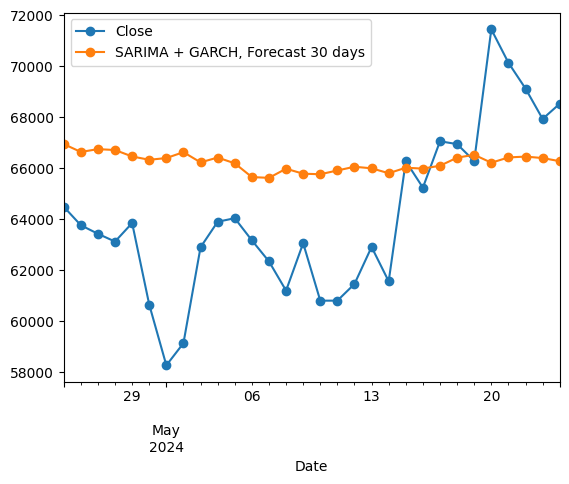

In [81]:
test_df_fc_with_GARCH = test.to_frame()
test_df_fc_with_GARCH['SARIMA + GARCH, Forecast 30 days'] = composite_forecast
test_df_fc_with_GARCH
test_df_fc_with_GARCH.plot(marker='o', label = True)

# rmse стал хуже для GARCH модели 1,1 (был около 3200 стал 3433) 

# LSTM

Для LSTM модели стационарность не является большой проблемой, но иногда покащатели на стационарном ряду лучше чем на не стационарном

Поэтому сейчас попробую обучить LSTM на нашем времянном ряду без изменений (приведения к стац.) и сравним прогноз с ARIMA

In [22]:
my_df = btc_history["Close"].to_frame(name='Close')

In [23]:
train_for_LSTM = my_df.iloc[:-30]
test_for_LSTM = my_df.iloc[-30:]

In [24]:
train_for_LSTM

,Close
Date,
2014-09-17 00:00:00+00:00,457.334015
2014-09-18 00:00:00+00:00,424.440002
2014-09-19 00:00:00+00:00,394.795990
2014-09-20 00:00:00+00:00,408.903992
2014-09-21 00:00:00+00:00,398.821014
...,...
2024-04-20 00:00:00+00:00,64994.441406
2024-04-21 00:00:00+00:00,64926.644531
2024-04-22 00:00:00+00:00,66837.679688


In [25]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_for_LSTM)
scaled_train_for_LSTM = scaler.transform(train_for_LSTM)
scaled_test_for_LSTM = scaler.transform(test_for_LSTM)

В качестве первой попытки я попробовал обучить модель предсказывать по последним 360 дням, но в дальнейшем я отказался от этого

In [26]:
# define generator
n_input = 360
n_features = 1
generator = TimeseriesGenerator(scaled_train_for_LSTM, scaled_train_for_LSTM, length=n_input, batch_size=1)


In [27]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-0.99233991 -0.99324228 -0.9940555  -0.99366848 -0.99394508 -0.99385371
 -0.99293089 -0.99327616 -0.99359523 -0.99379135 -0.99392591 -0.99453873
 -0.99458575 -0.9942709  -0.99436223 -0.99459659 -0.99502344 -0.99586415
 -0.99609338 -0.99583087 -0.99566331 -0.99520373 -0.99487218 -0.9949672
 -0.99494699 -0.9945012  -0.99417571 -0.99388887 -0.99405613 -0.99439128
 -0.99435831 -0.99414751 -0.99419952 -0.99438335 -0.99428377 -0.99437477
 -0.99505348 -0.99505546 -0.99535925 -0.99515534 -0.99520238 -0.9950754
 -0.99567966 -0.99541318 -0.99560477 -0.99594966 -0.99594573 -0.99590014
 -0.99581954 -0.99557281 -0.99530386 -0.99549246 -0.99540816 -0.99492051
 -0.99482011 -0.99479896 -0.9932664  -0.99334392 -0.9939726  -0.99456748
 -0.99424517 -0.99425818 -0.99459313 -0.99444617 -0.99506931 -0.99526112
 -0.99520428 -0.99480231 -0.99454641 -0.99458902 -0.99478044 -0.99474478
 -0.99455887 -0.99458509 -0.99451497 -0.99448211 -0.99442532 -0.99459829
 -0.99474659 -0.9945477  -0.9946044

In [34]:
# define model
LSTM_model_360 = Sequential()
LSTM_model_360.add(LSTM(100, input_shape=(n_input, n_features)))
LSTM_model_360.add(Dense(6))
LSTM_model_360.add(Dense(1))
LSTM_model_360.compile(optimizer='adam', loss='mse')

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [89]:
LSTM_model_360.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,406 (161.74 KB)

 Trainable params: 41,406 (161.74 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
LSTM_model_360.fit(generator,epochs=8, verbose = 0)

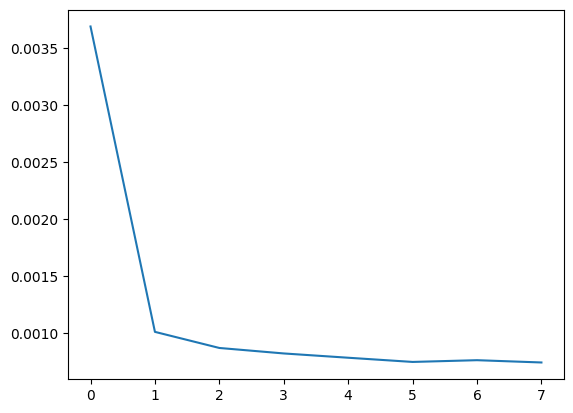

In [91]:
loss_per_epoch = LSTM_model_360.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [92]:
first_eval_batch = scaled_train_for_LSTM[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [93]:
len(current_batch[0])

360

In [94]:
test_predictions = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_360.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [95]:
true_predictions = scaler.inverse_transform(test_predictions)

In [96]:

test_for_LSTM['Predictions'] = true_predictions

C:\Users\User\AppData\Local\Temp\ipykernel_31572\1528477120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['Predictions'] = true_predictions


<Axes: xlabel='Date'>

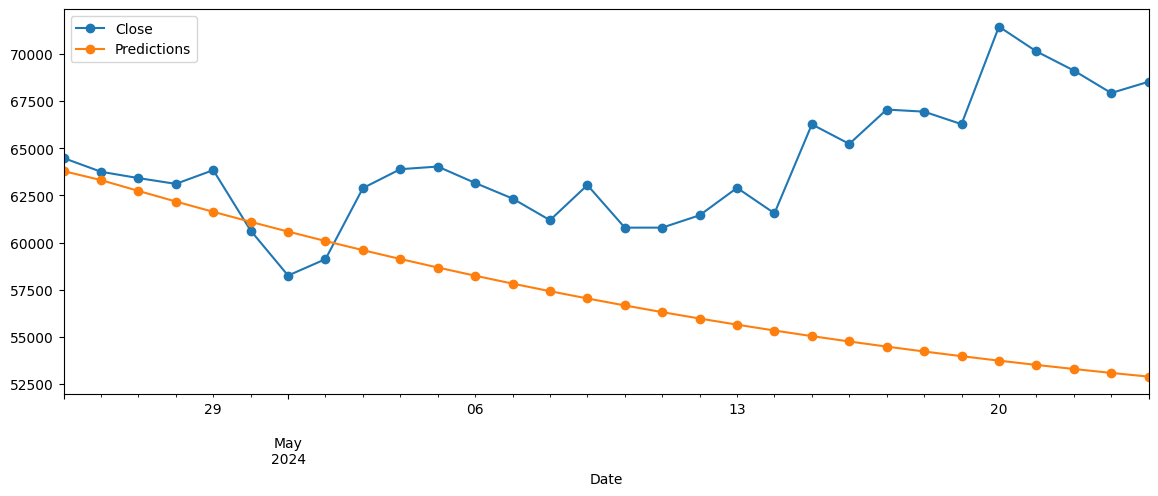

In [97]:
test_for_LSTM.plot(figsize=(14,5), marker='o', label = True)

In [98]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}")

Root Mean squared error: 8830.553363782052
Mean squared error: 77978672.71060252
SMAPE: 11.472016068249083


Это было Слепое предсказывание LSTM на модели со входом в 360 дней, результат так себе

Теперь попробую на модели в 30 дней

In [62]:
my_df = btc_history["Close"].to_frame(name='Close')
train_for_LSTM = my_df.iloc[:-30]
test_for_LSTM = my_df.iloc[-30:]

In [63]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_for_LSTM)
scaled_train_for_LSTM = scaler.transform(train_for_LSTM)
scaled_test_for_LSTM = scaler.transform(test_for_LSTM)

In [64]:
# define generator
n_input = 30
n_features = 1
generator_30 = TimeseriesGenerator(scaled_train_for_LSTM, scaled_train_for_LSTM, length=n_input, batch_size=1)

In [65]:
X,y = generator_30[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-0.99233991 -0.99324228 -0.9940555  -0.99366848 -0.99394508 -0.99385371
 -0.99293089 -0.99327616 -0.99359523 -0.99379135 -0.99392591 -0.99453873
 -0.99458575 -0.9942709  -0.99436223 -0.99459659 -0.99502344 -0.99586415
 -0.99609338 -0.99583087 -0.99566331 -0.99520373 -0.99487218 -0.9949672
 -0.99494699 -0.9945012  -0.99417571 -0.99388887 -0.99405613 -0.99439128]
Predict this y: 
 [[-0.99435831]]


In [ ]:
best_random_seed_for_default_LSTM = 0
best_rmse_for_default_LSTM = 10000
for el in range(0,50):
    keras.utils.set_random_seed(el)
    LSTM_model_30 = Sequential()
    #LSTM_model_with_Pos_vk_Crypto_bert.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
    LSTM_model_30.add(LSTM(100, input_shape=(n_input, n_features)))
    LSTM_model_30.add(Dense(6))
    LSTM_model_30.add(Dense(1))
    LSTM_model_30.compile(optimizer='adam', loss='mse')
    LSTM_model_30.fit(generator_30,epochs=12)
    first_eval_batch = scaled_train_for_LSTM[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    test_predictions = []
    for i in range(len(test_for_LSTM)):
        
        # get the prediction value for the first batch
        current_pred = LSTM_model_30.predict(current_batch)[0]
        current_pred = current_pred[-1:] 
        
        # append the prediction into the array
        test_predictions.append(current_pred) 
        
        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[scaled_test_for_LSTM[i]]],axis=1)

    my_df = btc_history["Close"].to_frame(name='Close')
    train_for_LSTM = my_df.iloc[:-30]
    test_for_LSTM = my_df.iloc[-30:]

    true_predictions = scaler.inverse_transform(test_predictions)
    test_for_LSTM['LSTM_Forecast'] = true_predictions

    rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['LSTM_Forecast']))
    # best_rmse_for_default_LSTM: 1841.7827179166818
    # best_random_seed_for_default_LSTM: 13
    if rmse < best_rmse_for_default_LSTM:
        best_rmse_for_default_LSTM = rmse
        best_random_seed_for_default_LSTM = el
    del LSTM_model_30

print("best_rmse_for_default_LSTM: " + str(best_rmse_for_default_LSTM))
print("best_random_seed_for_default_LSTM: " + str(best_random_seed_for_default_LSTM))
# тут оставил длинный вывод, дальше не буду

Epoch 1/12


  57/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.1437   

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0077
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0011
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.7607e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.1948e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.6623e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.4708e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.6927e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.0095e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0775e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.2997e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1353e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.7908e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0039
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.9403e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.5738e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9655e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.9096e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2591e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.0459e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3744e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 6.2871e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9386e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.9690e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0122e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0059
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 9.6053e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.7252e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.7063e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.1693e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.9516e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.2653e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.2691e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1130e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.0645e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.2876e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9591e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0101
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0011
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0010
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9370e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.2452e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.5307e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3157e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.8863e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.4280e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.4783e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.1734e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3305e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0114
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.7231e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 9.6801e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.4571e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.9948e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.7644e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.3255e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.0892e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.3036e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 6.6879e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.7363e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.7791e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0060
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.8023e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5126e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8483e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3372e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 7.4408e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2156e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0506e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4655e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.6096e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4132e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.3877e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0095
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0010
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.1540e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.7735e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.6721e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9276e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2041e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.7236e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9770e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2442e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9052e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8716e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0052
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.4631e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.3926e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.1678e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0551e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4180e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3822e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8940e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0646e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.6167e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.6379e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1282e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0068
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.2326e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 8.0450e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.2868e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4453e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.4588e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.3806e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.7500e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.5498e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8073e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.3741e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.7444e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0083
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 9.1874e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.9122e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 9.2560e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.3335e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.6627e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.6064e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3564e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0033e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.8841e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.3690e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.1494e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0077
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0010
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.6469e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2363e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.2550e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5024e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.7972e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.1313e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1541e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9469e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3051e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8006e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0070
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.8349e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.6609e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5003e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8365e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.3359e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9947e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3877e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.6144e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9025e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5308e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.9145e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0076
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0010
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.0609e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.4964e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 9.3090e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.0341e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.4548e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9827e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.1238e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.5950e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.0799e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.1775e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0042
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.7202e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.4908e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.3568e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.5920e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8691e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.3403e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 9.1265e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.2175e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.9913e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.2885e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.8605e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0067
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0010
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.0351e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.6453e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1346e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3600e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.3469e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.7291e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4468e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.2098e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.2456e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2087e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0075
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 9.6351e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 9.0135e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.3034e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.9081e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.7768e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.2102e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.9789e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.8262e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.4765e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.7743e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.4025e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0045
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.7993e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.8459e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.8276e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.3051e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.3293e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.9183e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.1810e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.8010e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.9801e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.0181e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.6519e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0060
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.3057e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.5404e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.4207e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5327e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9138e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3202e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.6815e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.4616e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9933e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.5093e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.2509e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0036
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.4861e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.7079e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4137e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4176e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4820e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9280e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4575e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9700e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3897e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1387e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8014e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0087
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0011
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.6369e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.2257e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.1823e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.7533e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.5837e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.2262e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.7496e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.3769e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.4788e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.7708e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0052
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.8423e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.0017e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.0406e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1687e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5672e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3099e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5176e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9914e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9250e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0166e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.3906e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0084
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0010
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0692e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4136e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3530e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5579e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0705e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.7302e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.6691e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.6215e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.6841e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3819e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0035
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.7008e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.9869e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9856e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8046e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.6264e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3870e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.5424e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.1566e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.1948e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3089e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3208e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0108
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 9.8558e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.0575e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3909e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1856e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5174e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9852e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.1828e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.7333e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.6091e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8843e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9892e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0062
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.2178e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9428e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.1220e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1198e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.1194e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2447e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0377e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1598e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8902e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2941e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.7422e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0086
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.5842e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9280e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.0013e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.6295e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0552e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.0472e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.8938e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5980e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9037e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.4654e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2880e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0069
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.3854e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.1139e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.3378e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9405e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0092e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2812e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8266e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5539e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.9268e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.0869e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1571e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0064
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.2765e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.6977e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4801e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1848e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.6136e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1880e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9233e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.0278e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.0791e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8542e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8636e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0070
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.1252e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.9383e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.6265e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.0419e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2454e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.4992e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9708e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9354e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1562e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.4450e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1868e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0068
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.9161e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.6748e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.7758e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.9790e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8535e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.4473e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1733e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9866e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.9397e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.6908e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2910e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0082
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.4210e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.1015e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.2459e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0387e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.0366e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0780e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8442e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.1348e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8977e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0130e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.5966e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0065
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0012
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.3464e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.2965e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0138e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8569e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5475e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8625e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8604e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1768e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2084e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1635e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0069
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.4231e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.7166e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.7358e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9533e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4770e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.7294e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.6464e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9685e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.7343e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.7005e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9235e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0053
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.1337e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.3970e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.7062e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9409e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.5730e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9098e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2406e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4248e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4513e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9124e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.2784e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0091
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.5501e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.7368e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.1616e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.9705e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9015e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0111e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3209e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.6374e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0838e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.3277e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1328e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0075
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.5956e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.3881e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.3661e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.9334e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.2444e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.1035e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.1320e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.2590e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.6492e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.7098e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.7748e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0102
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0011
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.3547e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4979e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.8506e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.7785e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9134e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8797e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.2278e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.3071e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.3587e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2730e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0060
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.6078e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.1602e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.7526e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.2198e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.7975e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1190e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8422e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.9771e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8060e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.6275e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.6520e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0050
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.5536e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.5535e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.2794e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.7669e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.3509e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.4264e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.8153e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.4567e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9826e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.1637e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.7389e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0057
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9338e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.3377e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.1960e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4409e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3528e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1449e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.0987e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1077e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3535e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5855e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8938e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0122
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0010
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.7369e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.4948e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 7.2143e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 7.7050e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 7.7914e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0274e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 7.4170e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.7384e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.9804e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4804e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0058
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.8801e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.2369e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.0899e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.5317e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.8339e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.3854e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.0995e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.0840e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.4664e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.0534e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.2958e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0056
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.3164e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.1438e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.1250e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.0228e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8962e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.1793e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0067e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2929e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8928e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.5592e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9330e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0074
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0010
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.6475e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.6102e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8172e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.6858e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.4618e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9313e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0415e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.2172e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2987e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0099e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0078
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 9.4596e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.4006e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.4340e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.3057e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.6973e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.8863e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.8672e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.2159e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.6479e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.3829e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.2033e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0051
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.1555e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.1537e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0071e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5792e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.9805e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0532e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2377e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8486e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.5889e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.0017e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.3770e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0042
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.4926e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.0706e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.1464e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.6621e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8798e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2737e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8309e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.4207e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.4697e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3869e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.5354e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0065
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.3564e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.7869e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.1764e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.1009e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0055e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9170e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.2614e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.6670e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0586e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8875e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.0001e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0060
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.9461e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.8440e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.1151e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.2965e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.6728e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.8461e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3574e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8940e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.7884e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5110e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9552e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0049
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.1353e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.1717e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.1248e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8866e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.0018e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.8325e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2035e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.8356e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.0632e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.2176e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.1015e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1754443817.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions


In [54]:
del LSTM_model_30

In [68]:
# define model
keras.utils.set_random_seed(best_random_seed_for_default_LSTM)
LSTM_model_30 = Sequential()
LSTM_model_30.add(LSTM(100, input_shape=(n_input, n_features)))
LSTM_model_30.add(Dense(6))
LSTM_model_30.add(Dense(1))
LSTM_model_30.compile(optimizer='adam', loss='mse')


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [69]:
LSTM_model_30.summary()

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_72 (LSTM)                  │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 6)              │           606 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,413 (161.77 KB)

 Trainable params: 41,413 (161.77 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
LSTM_model_30.fit(generator_30,epochs=12)

Epoch 1/12


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0042
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 8.7202e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.4908e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.3568e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.5920e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.8691e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.3403e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 9.1265e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.2175e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.9913e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.2885e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.8605e-04


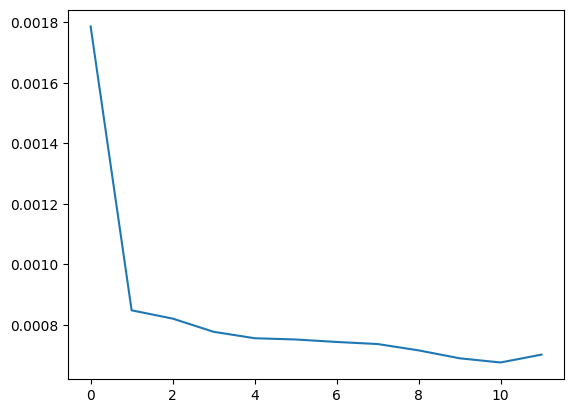

In [71]:
loss_per_epoch = LSTM_model_30.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [72]:
first_eval_batch = scaled_train_for_LSTM[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [73]:
test_predictions_30 = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_30.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions_30.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [76]:
my_df = btc_history["Close"].to_frame(name='Close')
train_for_LSTM = my_df.iloc[:-30]
test_for_LSTM = my_df.iloc[-30:]

In [77]:
true_predictions = scaler.inverse_transform(test_predictions_30)
test_for_LSTM['LSTM_Predictions 30 days'] = true_predictions

C:\Users\User\AppData\Local\Temp\ipykernel_22260\2095010557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Predictions 30 days'] = true_predictions


<Axes: xlabel='Date'>

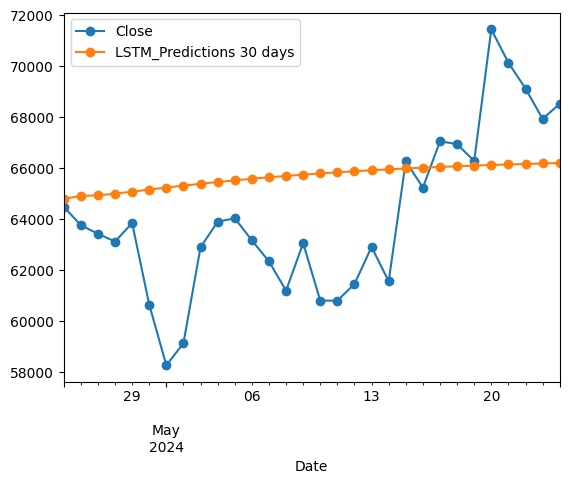

In [78]:
test_for_LSTM.plot( marker='o', label = True) #figsize=(14,5)

In [80]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['LSTM_Predictions 30 days']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['LSTM_Predictions 30 days'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['LSTM_Predictions 30 days'])}")

## тут находил лучше RMSE: 3274, SMAPE: 4.04 рандомным подбором (но это все еще хуже аримы)

Root Mean squared error: 3335.6827998363656
Mean squared error: 11126779.741124174
SMAPE: 4.328423432569462


Теперь попробую предсказывать на 1 день вперед 30 раз (не слепо) используя модель на 30 днях

In [81]:
first_eval_batch = scaled_train_for_LSTM[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [82]:
test_predictions = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_30.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[scaled_test_for_LSTM[i]]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [83]:
my_df = btc_history["Close"].to_frame(name='Close')
train_for_LSTM = my_df.iloc[:-30]
test_for_LSTM = my_df.iloc[-30:]

In [84]:
true_predictions = scaler.inverse_transform(test_predictions)
test_for_LSTM['LSTM_Forecast'] = true_predictions

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1930892984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions


<Axes: xlabel='Date'>

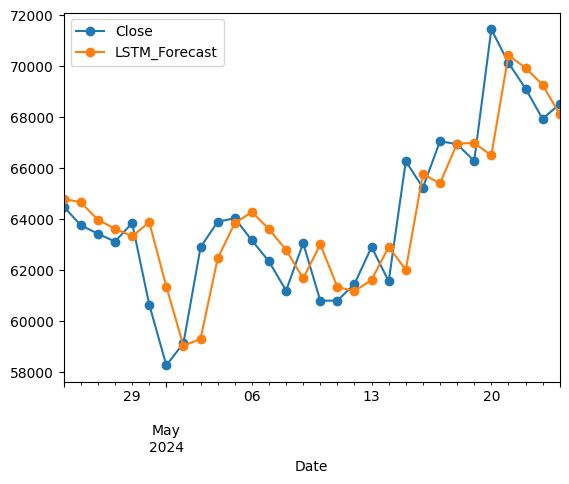

In [85]:
test_for_LSTM.plot(marker='o', label = True) #figsize=(14,5)

In [86]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['LSTM_Forecast']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['LSTM_Forecast'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['LSTM_Forecast'])}")

# Root Mean squared error: 1841.7827179166818
# Mean squared error: 3392163.5800165595
# SMAPE: 2.114925055299612

Root Mean squared error: 1841.7827179166818
Mean squared error: 3392163.5800165595
SMAPE: 2.114925055299612


# Выводы без SENTIMENT, чисто сравнение между LSTM и SARIMA :

SARIMA (по 1 дню с добавлением предсказаний в окно):

Root Mean squared error: 3179

SMAPE: 3.68


LSTM (по 1 дню с добавлением предсказаний в окно):

Root Mean squared error: 3274

SMAPE: 4.04


SARIMA (по 1 дню с добавлением настоящих значений в окно):

Root Mean squared error:  1940

SMAPE: 2.23


LSTM (по 1 дню с добавлением настоящих значений в окно):

Root Mean squared error: 1875

SMAPE: 2.12

Вывод LSTM и SARIMA хоть и кардинально отличаются в технологии, но прогнозы дают довольно близкие, SARIMA немного лучше на моем датасете в слепом предсказывании на 30 дней, LSTM лучше в предсказывании по 1 дню на 30 дней с добавлением настоящих значений в окно прогноза

# Теперь Попробую добавить к LSTM временной ряд отражающий SETIMENT анализ новостей криптовалюты с сайта РБК

Импортирую данные рбк 

In [87]:
train_for_LSTM.index = train_for_LSTM.index.date # убрал точное время из даты (оно не нужно)
test_for_LSTM.index = test_for_LSTM.index.date
my_df.index = my_df.index.date

In [88]:
rbk_RuBeart_Titles_Sentiment = pd.read_csv('rbk_RuBeart_Titles_Sentiment.csv')

In [89]:
rbk_RuBeart_Titles_Sentiment

,publish_date,rbk_positive,rbk_negative
0,2017-12-08,0.508701,0.491299
1,2018-02-07,0.368749,0.631251
2,2018-02-26,0.517286,0.482714
3,2018-02-26,0.401239,0.598761
4,2018-03-01,0.315074,0.684926
...,...,...,...
12370,2024-05-24,0.537387,0.462613
12371,2024-05-23,0.532352,0.467648
12372,2024-05-23,0.503831,0.496169
12373,2024-05-23,0.005241,0.994759


In [90]:
my_df

,Close
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2024-05-20,71448.195312
2024-05-21,70136.531250
2024-05-22,69122.335938
2024-05-23,67929.562500


In [91]:
my_df['date'] = my_df.index
my_df['date'] = pd.to_datetime(my_df['date']).dt.date

In [92]:
# Убедимся, что publish_date в формате datetime
rbk_RuBeart_Titles_Sentiment['publish_date'] = pd.to_datetime(rbk_RuBeart_Titles_Sentiment['publish_date'])


In [93]:
# Шаг 2: Агрегация значений rbk_positive и rbk_negative по дням
rbk_RuBeart_Titles_Sentiment = rbk_RuBeart_Titles_Sentiment.groupby('publish_date').mean().reset_index()


In [94]:
# Преобразование publish_date в дату без времени
rbk_RuBeart_Titles_Sentiment['publish_date'] = rbk_RuBeart_Titles_Sentiment['publish_date'].apply(lambda x: x.date())

In [95]:
# Объединение данных
merged_df = pd.merge(my_df, rbk_RuBeart_Titles_Sentiment, how='left', left_on='date', right_on='publish_date')

In [96]:
merged_df.set_index('date', inplace=True)
merged_df.drop(columns=['publish_date'], inplace=True)

In [97]:
merged_df

,Close,rbk_positive,rbk_negative
date,,,
2014-09-17,457.334015,NaN,NaN
2014-09-18,424.440002,NaN,NaN
2014-09-19,394.795990,NaN,NaN
2014-09-20,408.903992,NaN,NaN
2014-09-21,398.821014,NaN,NaN
...,...,...,...
2024-05-20,71448.195312,0.404926,0.595074
2024-05-21,70136.531250,0.412522,0.587478
2024-05-22,69122.335938,0.482541,0.517459


In [98]:
# # Шаг 3: Замаскировать пропуски в данных rbk_RuBeart_Titles_Sentiment
# merged_df['rbk_positive'] = np.ma.masked_invalid(merged_df['rbk_positive'])
# merged_df['rbk_negative'] = np.ma.masked_invalid(merged_df['rbk_negative'])

In [99]:
# Замена маскированных значений на -1
merged_df['rbk_positive'] = merged_df['rbk_positive'].fillna(-1)
merged_df['rbk_negative'] = merged_df['rbk_negative'].fillna(-1)

In [100]:
merged_df

,Close,rbk_positive,rbk_negative
date,,,
2014-09-17,457.334015,-1.000000,-1.000000
2014-09-18,424.440002,-1.000000,-1.000000
2014-09-19,394.795990,-1.000000,-1.000000
2014-09-20,408.903992,-1.000000,-1.000000
2014-09-21,398.821014,-1.000000,-1.000000
...,...,...,...
2024-05-20,71448.195312,0.404926,0.595074
2024-05-21,70136.531250,0.412522,0.587478
2024-05-22,69122.335938,0.482541,0.517459


# Данные почти готовы


In [124]:
train_for_LSTM = merged_df.iloc[:-30]
test_for_LSTM = merged_df.iloc[-30:]

In [125]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_train_for_LSTM = scaler.transform(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_test_for_LSTM = scaler.transform(test_for_LSTM['Close'].values.reshape(-1, 1))

In [126]:
# merged_df['Close'].values.reshape((len(merged_df['Close'].values), 1))

In [127]:
dataset = hstack((scaled_train_for_LSTM, train_for_LSTM['rbk_positive'].values.reshape((-1, 1)), train_for_LSTM['rbk_negative'].values.reshape((-1, 1))))

In [128]:
n_input = 30
generator = TimeseriesGenerator(dataset, scaled_train_for_LSTM, length=n_input, batch_size=1)

In [129]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[ 0.00383005 -1.         -1.          0.00337886 -1.         -1.
  0.00297225 -1.         -1.          0.00316576 -1.         -1.
  0.00302746 -1.         -1.          0.00307315 -1.         -1.
  0.00353455 -1.         -1.          0.00336192 -1.         -1.
  0.00320238 -1.         -1.          0.00310432 -1.         -1.
  0.00303705 -1.         -1.          0.00273063 -1.         -1.
  0.00270712 -1.         -1.          0.00286455 -1.         -1.
  0.00281889 -1.         -1.          0.00270171 -1.         -1.
  0.00248828 -1.         -1.          0.00206793 -1.         -1.
  0.00195331 -1.         -1.          0.00208456 -1.         -1.
  0.00216834 -1.         -1.          0.00239814 -1.         -1.
  0.00256391 -1.         -1.          0.0025164  -1.         -1.
  0.00252651 -1.         -1.          0.0027494  -1.         -1.
  0.00291214 -1.         -1.          0.00305556 -1.         -1.
  0.00297193 -1.         -1.          0.00280436 -1.         -1.        

In [130]:
n_features = X.shape[2]
n_features

3

In [131]:
mask = np.float64(-1)

In [132]:
X[0][0][1] == mask # сравниваю что mask == числу вставленному в генератор

True

In [ ]:
best_random_seed_for_rubert_rbk = 0
best_rmse_for_rubert_rbk = 10000
for el in range(0,50):
    keras.utils.set_random_seed(el)
    LSTM_model_with_Pos_rbk = Sequential()
    LSTM_model_with_Pos_rbk.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
    LSTM_model_with_Pos_rbk.add(LSTM(100, input_shape=(n_input, n_features)))
    LSTM_model_with_Pos_rbk.add(Dense(6))
    LSTM_model_with_Pos_rbk.add(Dense(1))
    LSTM_model_with_Pos_rbk.compile(optimizer='adam', loss='mse')
    LSTM_model_with_Pos_rbk.fit(generator,epochs=12)

    first_eval_batch = generator[-n_input-1][0]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    test_predictions_30 = []
    for i in range(len(test_for_LSTM)):
        
        # get the prediction value for the first batch
        current_pred = LSTM_model_with_Pos_rbk.predict(current_batch)[0]
        current_pred = current_pred[-1:] 
        
        # append the prediction into the array
        test_predictions_30.append(current_pred) 
        
        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['rbk_positive'].iloc[i] , test_for_LSTM['rbk_negative'].iloc[i]]) ]],axis=1)

    train_for_LSTM = merged_df.iloc[:-30]
    test_for_LSTM = merged_df.iloc[-30:]

    true_predictions = scaler.inverse_transform(test_predictions_30)
    test_for_LSTM['LSTM_Forecast'] = true_predictions

    rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['LSTM_Forecast']))
    # Лучший получившийся
    # best_rmse_for_rubert_rbk: 1895.9141596660804
    # best_random_seed_for_rubert_rbk: 35
    if rmse < best_rmse_for_rubert_rbk:
        best_rmse_for_rubert_rbk = rmse
        best_random_seed_for_rubert_rbk = el
    del LSTM_model_with_Pos_rbk

print("best_rmse_for_rubert_rbk: " + str(best_rmse_for_rubert_rbk))
print("best_random_seed_for_rubert_rbk: " + str(best_random_seed_for_rubert_rbk))

In [136]:
# define model
keras.utils.set_random_seed(best_random_seed_for_rubert_rbk)
LSTM_model_with_Pos_rbk = Sequential()
LSTM_model_with_Pos_rbk.add(Masking(mask_value=True, input_shape=(n_input, n_features)))
LSTM_model_with_Pos_rbk.add(LSTM(100))
LSTM_model_with_Pos_rbk.add(Dense(6))
LSTM_model_with_Pos_rbk.add(Dense(1))
LSTM_model_with_Pos_rbk.compile(optimizer='adam', loss='mse')


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [137]:
LSTM_model_with_Pos_rbk.fit(generator,epochs=12)

Epoch 1/12


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.0032
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 4.4633e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 3.5512e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 3.0147e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.5643e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.6394e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.5124e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.6767e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.1556e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.3868e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 2.0877e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.3360e-04


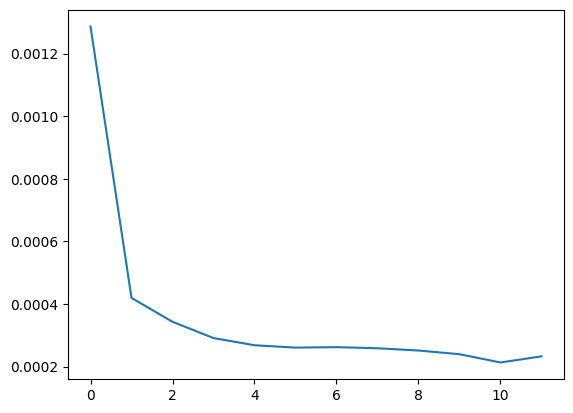

In [138]:
loss_per_epoch = LSTM_model_with_Pos_rbk.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [139]:
first_eval_batch = generator[-n_input-1][0]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [140]:
test_predictions_30 = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_with_Pos_rbk.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions_30.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['rbk_positive'].iloc[i] , test_for_LSTM['rbk_negative'].iloc[i]]) ]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━

In [141]:
true_predictions = scaler.inverse_transform(test_predictions_30)
test_for_LSTM['Predictions'] = true_predictions

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1492626813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['Predictions'] = true_predictions


In [142]:
columns_to_plot = ['Close', 'Predictions']

<Axes: xlabel='date'>

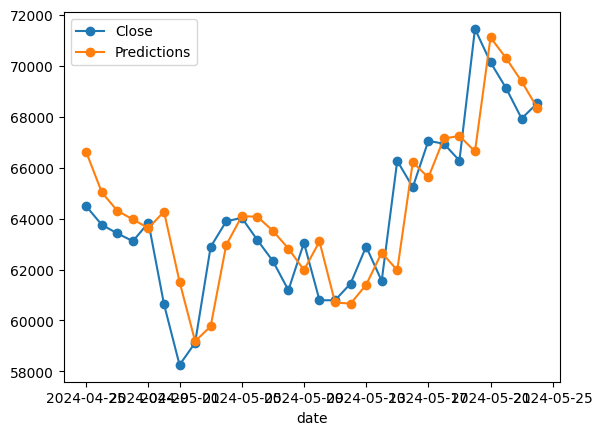

In [143]:
test_for_LSTM[columns_to_plot].plot( marker='o', label = True)

In [144]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}")

# Лучший получившийся
# keras.utils.set_random_seed(35)
# Root Mean squared error: 1895.9141596660804
# Mean squared error: 3594490.5008223397
# SMAPE: 2.262871484953463

Root Mean squared error: 1895.9141596660804
Mean squared error: 3594490.5008223397
SMAPE: 2.262871484953463


Предсказания модели LSTM не стали лучше после добавления sentiment - От этого берта blanchefort/rubert-base-cased-sentiment-mokoron



Лучший RMSE обычной LSTM модели был 1875

# ПОПРОБУЮ Crypto Bert Для РБК 

In [145]:
rbk_data_from_cryptobert = pd.read_csv('rbk_cryptobert_Titles_sentiment.csv')

In [146]:
# Убедимся, что publish_date в формате datetime
rbk_data_from_cryptobert['publish_date'] = pd.to_datetime(rbk_data_from_cryptobert['publish_date'])

In [147]:
# Шаг 2: Агрегация значений rbk_positive и rbk_negative по дням
rbk_data_from_cryptobert = rbk_data_from_cryptobert.groupby('publish_date').mean().reset_index()

In [148]:
# Преобразование publish_date в дату без времени
rbk_data_from_cryptobert['publish_date'] = rbk_data_from_cryptobert['publish_date'].apply(lambda x: x.date())

In [159]:
my_df['date'] = my_df.index
my_df['date'] = pd.to_datetime(my_df['date']).dt.date

In [160]:
# Объединение данных
merged_df_cryptoBert = pd.merge(my_df, rbk_data_from_cryptobert, how='left', left_on='date', right_on='publish_date')
merged_df_cryptoBert.set_index('date', inplace=True)
merged_df_cryptoBert.drop(columns=['publish_date'], inplace=True)
merged_df_cryptoBert

,Close,rbk_postive_cryptobert,rbk_negative_cryptobert,rbk_neutral_cryptobert
date,,,,
2014-09-17,457.334015,NaN,NaN,NaN
2014-09-18,424.440002,NaN,NaN,NaN
2014-09-19,394.795990,NaN,NaN,NaN
2014-09-20,408.903992,NaN,NaN,NaN
2014-09-21,398.821014,NaN,NaN,NaN
...,...,...,...,...
2024-05-20,71448.195312,0.321901,0.227655,0.450444
2024-05-21,70136.531250,0.502853,0.012236,0.484911
2024-05-22,69122.335938,0.372676,0.040811,0.586513


In [161]:
# Шаг 3: Замаскировать пропуски в данных rbk_RuBeart_Titles_Sentiment
merged_df_cryptoBert['rbk_postive_cryptobert'] = np.ma.masked_invalid(merged_df_cryptoBert['rbk_postive_cryptobert'])
merged_df_cryptoBert['rbk_negative_cryptobert'] = np.ma.masked_invalid(merged_df_cryptoBert['rbk_negative_cryptobert'])
merged_df_cryptoBert['rbk_neutral_cryptobert'] = np.ma.masked_invalid(merged_df_cryptoBert['rbk_neutral_cryptobert'])

# Замена маскированных значений на -1
merged_df_cryptoBert['rbk_postive_cryptobert'] = merged_df_cryptoBert['rbk_postive_cryptobert'].fillna(np.float64(-1))
merged_df_cryptoBert['rbk_negative_cryptobert'] = merged_df_cryptoBert['rbk_negative_cryptobert'].fillna(np.float64(-1))
merged_df_cryptoBert['rbk_neutral_cryptobert'] = merged_df_cryptoBert['rbk_neutral_cryptobert'].fillna(np.float64(-1))
merged_df_cryptoBert

,Close,rbk_postive_cryptobert,rbk_negative_cryptobert,rbk_neutral_cryptobert
date,,,,
2014-09-17,457.334015,-1.000000,-1.000000,-1.000000
2014-09-18,424.440002,-1.000000,-1.000000,-1.000000
2014-09-19,394.795990,-1.000000,-1.000000,-1.000000
2014-09-20,408.903992,-1.000000,-1.000000,-1.000000
2014-09-21,398.821014,-1.000000,-1.000000,-1.000000
...,...,...,...,...
2024-05-20,71448.195312,0.321901,0.227655,0.450444
2024-05-21,70136.531250,0.502853,0.012236,0.484911
2024-05-22,69122.335938,0.372676,0.040811,0.586513


In [162]:
# merged_df_cryptoBert.iloc[1178:-30]

# Данные почти готовы

In [163]:
n_input = 30
train_for_LSTM = merged_df_cryptoBert.iloc[:-n_input]
test_for_LSTM = merged_df_cryptoBert.iloc[-n_input:]

In [164]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_train_for_LSTM = scaler.transform(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_test_for_LSTM = scaler.transform(test_for_LSTM['Close'].values.reshape(-1, 1))

In [165]:
dataset = hstack((scaled_train_for_LSTM, train_for_LSTM['rbk_postive_cryptobert'].values.reshape((-1, 1)), train_for_LSTM['rbk_negative_cryptobert'].values.reshape((-1, 1)), train_for_LSTM['rbk_neutral_cryptobert'].values.reshape((-1, 1))))

In [166]:

generator = TimeseriesGenerator(dataset, scaled_train_for_LSTM, length=n_input, batch_size=1)

In [167]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[ 0.00383005 -1.         -1.         -1.          0.00337886 -1.
 -1.         -1.          0.00297225 -1.         -1.         -1.
  0.00316576 -1.         -1.         -1.          0.00302746 -1.
 -1.         -1.          0.00307315 -1.         -1.         -1.
  0.00353455 -1.         -1.         -1.          0.00336192 -1.
 -1.         -1.          0.00320238 -1.         -1.         -1.
  0.00310432 -1.         -1.         -1.          0.00303705 -1.
 -1.         -1.          0.00273063 -1.         -1.         -1.
  0.00270712 -1.         -1.         -1.          0.00286455 -1.
 -1.         -1.          0.00281889 -1.         -1.         -1.
  0.00270171 -1.         -1.         -1.          0.00248828 -1.
 -1.         -1.          0.00206793 -1.         -1.         -1.
  0.00195331 -1.         -1.         -1.          0.00208456 -1.
 -1.         -1.          0.00216834 -1.         -1.         -1.
  0.00239814 -1.         -1.         -1.          0.00256391 -1.
 -1.   

In [168]:
n_features = X.shape[2]
n_features

4

In [170]:
my_mask = np.float64(-1)

In [172]:
X[0][1][1] == mask

True

In [ ]:
best_random_seed_for_crypto_bert_rbk = 0
best_rmse_for_crypto_bert_rbk = 10000
for el in range(0,50):
    keras.utils.set_random_seed(el)
    LSTM_model_with_Pos_rbk = Sequential()
    LSTM_model_with_Pos_rbk.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
    LSTM_model_with_Pos_rbk.add(LSTM(100, input_shape=(n_input, n_features)))
    LSTM_model_with_Pos_rbk.add(Dense(6))
    LSTM_model_with_Pos_rbk.add(Dense(1))
    LSTM_model_with_Pos_rbk.compile(optimizer='adam', loss='mse')
    LSTM_model_with_Pos_rbk.fit(generator,epochs=12)

    first_eval_batch = generator[-n_input-1][0]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    test_predictions_30 = []
    for i in range(len(test_for_LSTM)):
        
        # get the prediction value for the first batch
        current_pred = LSTM_model_with_Pos_rbk.predict(current_batch)[0]
        current_pred = current_pred[-1:] 
        
        # append the prediction into the array
        test_predictions_30.append(current_pred) 
        
        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],  [[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['rbk_postive_cryptobert'].iloc[i] , test_for_LSTM['rbk_negative_cryptobert'].iloc[i], test_for_LSTM['rbk_neutral_cryptobert'].iloc[i] ]) ]]      ,axis=1)

    test_for_LSTM = merged_df_cryptoBert.iloc[-n_input:]

    true_predictions = scaler.inverse_transform(test_predictions_30)
    test_for_LSTM['Predictions'] = true_predictions
    
    rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))

    # best_rmse_for_crypto_bert_rbk: 1911.0226314135966
    # best_random_seed_for_crypto_bert_rbk: 37
    if rmse < best_rmse_for_crypto_bert_rbk:
        best_rmse_for_crypto_bert_rbk = rmse
        best_random_seed_for_crypto_bert_rbk = el
    del LSTM_model_with_Pos_rbk

print("best_rmse_for_crypto_bert_rbk: " + str(best_rmse_for_crypto_bert_rbk))
print("best_random_seed_for_crypto_bert_rbk: " + str(best_random_seed_for_crypto_bert_rbk))

In [177]:
# define model
keras.utils.set_random_seed(best_random_seed_for_crypto_bert_rbk)
LSTM_model_with_Pos_rbk = Sequential()
LSTM_model_with_Pos_rbk.add(Masking(mask_value=my_mask, input_shape=(n_input, n_features)))
LSTM_model_with_Pos_rbk.add(LSTM(100, input_shape=(n_input, n_features)))
LSTM_model_with_Pos_rbk.add(Dense(6))
LSTM_model_with_Pos_rbk.add(Dense(1))
LSTM_model_with_Pos_rbk.compile(optimizer='adam', loss='mse')

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [570]:
# # define model
# LSTM_model_with_Pos_rbk = Sequential()
# LSTM_model_with_Pos_rbk.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
# LSTM_model_with_Pos_rbk.add(LSTM(50, return_sequences=True))  # Первый слой LSTM
# LSTM_model_with_Pos_rbk.add(LSTM(50, return_sequences=True))  # Второй слой LSTM
# LSTM_model_with_Pos_rbk.add(LSTM(50))  # Третий (последний) слой LSTM, return_sequences=False по умолчанию
# LSTM_model_with_Pos_rbk.add(Dense(1))
# LSTM_model_with_Pos_rbk.compile(optimizer='adam', loss='mse')

In [178]:
LSTM_model_with_Pos_rbk.fit(generator,epochs=12)

Epoch 1/12


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.0042
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 4.9494e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 4.1481e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.9825e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.3551e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 3.4004e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.5790e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.5115e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.3611e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.1657e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.5221e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.7155e-04


In [179]:
LSTM_model_with_Pos_rbk.summary()

Model: "sequential_181"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_106 (Masking)           │ (None, 30, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_179 (LSTM)                 │ (None, 100)            │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_357 (Dense)               │ (None, 6)              │           606 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_358 (Dense)               │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,841 (499.38 KB)

 Trainable params: 42,613 (166.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 85,228 (332.93 KB)

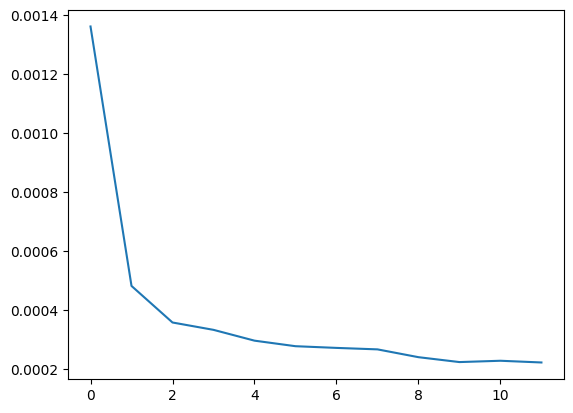

In [180]:
loss_per_epoch = LSTM_model_with_Pos_rbk.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [181]:
first_eval_batch = generator[-n_input-1][0]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [575]:
# test_predictions_30 = []
# for i in range(len(test_for_LSTM)):
    
#     # get the prediction value for the first batch
#     current_pred = LSTM_model_with_Pos_rbk.predict(current_batch)[0]
#     current_pred = current_pred[-1:] 
    
#     # append the prediction into the array
#     test_predictions_30.append(current_pred) 
    
#     # use the prediction to update the batch and remove the first value
#     current_batch = np.append(current_batch[:,1:,:],   [[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['rbk_positive'].iloc[i] , test_for_LSTM['rbk_negative'].iloc[i]]) ]]     ,axis=1)

In [182]:
test_predictions_30 = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_with_Pos_rbk.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions_30.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],  [[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['rbk_postive_cryptobert'].iloc[i] , test_for_LSTM['rbk_negative_cryptobert'].iloc[i], test_for_LSTM['rbk_neutral_cryptobert'].iloc[i] ]) ]]      ,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━

In [183]:
true_predictions = scaler.inverse_transform(test_predictions_30)
test_for_LSTM['Predictions'] = true_predictions

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1492626813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['Predictions'] = true_predictions


<Axes: xlabel='date'>

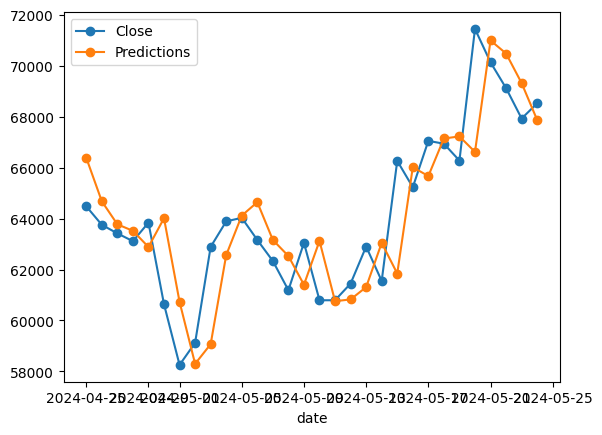

In [184]:
columns_to_plot = ['Close', 'Predictions']
test_for_LSTM[columns_to_plot].plot(marker='o', label = True)

In [185]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}")

# keras.utils.set_random_seed(37)
# Root Mean squared error: 1911.0226314135966
# Mean squared error: 3652007.497774947
# SMAPE: 2.3285352541926105

Root Mean squared error: 1911.0226314135966
Mean squared error: 3652007.497774947
SMAPE: 2.3285352541926105


# Попробую добавить данные с ВК

In [186]:
vk_data_from_rubeart = pd.read_csv('vk_RuBeart_text_Sentiment.csv')
#vk_data_from_rubeart = vk_data_from_rubeart.rename(columns={'Дата и время публикации': 'publish_date'}) # переименовал в publish_date что бы привычнеебыло

In [187]:
vk_data_from_rubeart_v2 = pd.read_excel('vk_RuBeart_text_Sentiment_v2_excel.xlsx')

In [188]:
vk_data_from_rubeart = vk_data_from_rubeart_v2

In [189]:
vk_data_from_rubeart

,publish_date,vk_posotive_rubert,vk_negative_rubert
0,2022-10-19,0.527412,0.472588
1,2024-05-24,0.479314,0.520686
2,2024-05-23,0.000120,0.999880
3,2024-05-23,0.671547,0.328453
4,2024-05-23,0.550594,0.449406
...,...,...,...
12507,2017-04-12,0.553791,0.446209
12508,2017-04-05,0.503072,0.496928
12509,2017-04-05,0.443439,0.556561
12510,2017-04-05,0.418640,0.581360


In [190]:

# Убедимся, что publish_date в формате datetime
vk_data_from_rubeart['publish_date'] = pd.to_datetime(vk_data_from_rubeart['publish_date'])
# Шаг 2: Агрегация значений rbk_positive и rbk_negative по дням
vk_data_from_rubeart = vk_data_from_rubeart.groupby('publish_date').mean().reset_index()
# Преобразование publish_date в дату без времени
vk_data_from_rubeart['publish_date'] = vk_data_from_rubeart['publish_date'].apply(lambda x: x.date())

In [191]:

# Объединение данных
merged_df_VK_ruBert = pd.merge(my_df, vk_data_from_rubeart, how='left', left_on='date', right_on='publish_date')
merged_df_VK_ruBert.set_index('date', inplace=True)
merged_df_VK_ruBert.drop(columns=['publish_date'], inplace=True)
merged_df_VK_ruBert

,Close,vk_posotive_rubert,vk_negative_rubert
date,,,
2014-09-17,457.334015,NaN,NaN
2014-09-18,424.440002,NaN,NaN
2014-09-19,394.795990,NaN,NaN
2014-09-20,408.903992,NaN,NaN
2014-09-21,398.821014,NaN,NaN
...,...,...,...
2024-05-20,71448.195312,0.587997,0.412003
2024-05-21,70136.531250,0.500050,0.499950
2024-05-22,69122.335938,0.440496,0.559504


In [192]:
# Шаг 3: Замаскировать пропуски в данных rbk_RuBeart_Titles_Sentiment
merged_df_VK_ruBert['vk_posotive_rubert'] = np.ma.masked_invalid(merged_df_VK_ruBert['vk_posotive_rubert'])
merged_df_VK_ruBert['vk_negative_rubert'] = np.ma.masked_invalid(merged_df_VK_ruBert['vk_negative_rubert'])

# Замена маскированных значений на -1
merged_df_VK_ruBert['vk_posotive_rubert'] = merged_df_VK_ruBert['vk_posotive_rubert'].fillna(np.float64(-1))
merged_df_VK_ruBert['vk_negative_rubert'] = merged_df_VK_ruBert['vk_negative_rubert'].fillna(np.float64(-1))

# Данные почти готовы

In [193]:
# Данные почти готовы
n_input = 30
train_for_LSTM = merged_df_VK_ruBert.iloc[:-n_input]
test_for_LSTM = merged_df_VK_ruBert.iloc[-n_input:]

In [194]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_train_for_LSTM = scaler.transform(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_test_for_LSTM = scaler.transform(test_for_LSTM['Close'].values.reshape(-1, 1))

In [195]:
dataset = hstack((scaled_train_for_LSTM, train_for_LSTM['vk_posotive_rubert'].values.reshape((-1, 1)), train_for_LSTM['vk_negative_rubert'].values.reshape((-1, 1))))

In [196]:
generator = TimeseriesGenerator(dataset, scaled_train_for_LSTM, length=n_input, batch_size=1)
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[ 0.00383005 -1.         -1.          0.00337886 -1.         -1.
  0.00297225 -1.         -1.          0.00316576 -1.         -1.
  0.00302746 -1.         -1.          0.00307315 -1.         -1.
  0.00353455 -1.         -1.          0.00336192 -1.         -1.
  0.00320238 -1.         -1.          0.00310432 -1.         -1.
  0.00303705 -1.         -1.          0.00273063 -1.         -1.
  0.00270712 -1.         -1.          0.00286455 -1.         -1.
  0.00281889 -1.         -1.          0.00270171 -1.         -1.
  0.00248828 -1.         -1.          0.00206793 -1.         -1.
  0.00195331 -1.         -1.          0.00208456 -1.         -1.
  0.00216834 -1.         -1.          0.00239814 -1.         -1.
  0.00256391 -1.         -1.          0.0025164  -1.         -1.
  0.00252651 -1.         -1.          0.0027494  -1.         -1.
  0.00291214 -1.         -1.          0.00305556 -1.         -1.
  0.00297193 -1.         -1.          0.00280436 -1.         -1.        

In [197]:
n_features = X.shape[2]
n_features


3

In [199]:
mask = np.float64(-1)

numpy.float64

In [200]:
X[0][1][1] == mask 

True

In [ ]:
best_random_seed_for_rubert_vk = 0
best_rmse_for_rubert_vk = 10000
for el in range(0,50):
    keras.utils.set_random_seed(el)
    LSTM_model_with_Pos_vk_ru_bert = Sequential()
    LSTM_model_with_Pos_vk_ru_bert.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
    LSTM_model_with_Pos_vk_ru_bert.add(LSTM(100, input_shape=(n_input, n_features)))
    LSTM_model_with_Pos_vk_ru_bert.add(Dense(6))
    LSTM_model_with_Pos_vk_ru_bert.add(Dense(1))
    LSTM_model_with_Pos_vk_ru_bert.compile(optimizer='adam', loss='mse')
    LSTM_model_with_Pos_vk_ru_bert.fit(generator,epochs=12)

    first_eval_batch = generator[-n_input-1][0]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    test_predictions_30 = []
    for i in range(len(test_for_LSTM)):
        
        # get the prediction value for the first batch
        current_pred = LSTM_model_with_Pos_vk_ru_bert.predict(current_batch)[0]
        current_pred = current_pred[-1:] 
        
        # append the prediction into the array
        test_predictions_30.append(current_pred) 
        
        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],  [[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['vk_posotive_rubert'].iloc[i] , test_for_LSTM['vk_negative_rubert'].iloc[i]]) ]],axis=1)
        
    test_for_LSTM = merged_df_VK_ruBert.iloc[-n_input:]

    true_predictions = scaler.inverse_transform(test_predictions_30)
    test_for_LSTM['Predictions'] = true_predictions
    
    rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))

    # best_rmse_for_rubert_vk: 1832.2640250867648
    # best_random_seed_for_rubert_vk: 42
    if rmse < best_rmse_for_rubert_vk:
        best_rmse_for_rubert_vk = rmse
        best_random_seed_for_rubert_vk = el
    del LSTM_model_with_Pos_vk_ru_bert

print("best_rmse_for_rubert_vk: " + str(best_rmse_for_rubert_vk))
print("best_random_seed_for_rubert_vk: " + str(best_random_seed_for_rubert_vk))

In [226]:
# define model
keras.utils.set_random_seed(42)
LSTM_model_with_Pos_vk_ru_bert = Sequential()
LSTM_model_with_Pos_vk_ru_bert.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
LSTM_model_with_Pos_vk_ru_bert.add(LSTM(100, input_shape=(n_input, n_features)))
LSTM_model_with_Pos_vk_ru_bert.add(Dense(6))
LSTM_model_with_Pos_vk_ru_bert.add(Dense(1))
LSTM_model_with_Pos_vk_ru_bert.compile(optimizer='adam', loss='mse')

In [227]:
LSTM_model_with_Pos_vk_ru_bert.fit(generator,epochs=12)


Epoch 1/12
 189/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0125

3478/3478 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.0023
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 4.3704e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 3.9982e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 3.1120e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 3.1279e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.7253e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.1732e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.3306e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.5505e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.2539e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.2868e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.4777e-04


In [228]:
LSTM_model_with_Pos_vk_ru_bert.summary()

Model: "sequential_235"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_160 (Masking)           │ (None, 30, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_233 (LSTM)                 │ (None, 100)            │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_465 (Dense)               │ (None, 6)              │           606 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_466 (Dense)               │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,641 (494.70 KB)

 Trainable params: 42,213 (164.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 84,428 (329.80 KB)

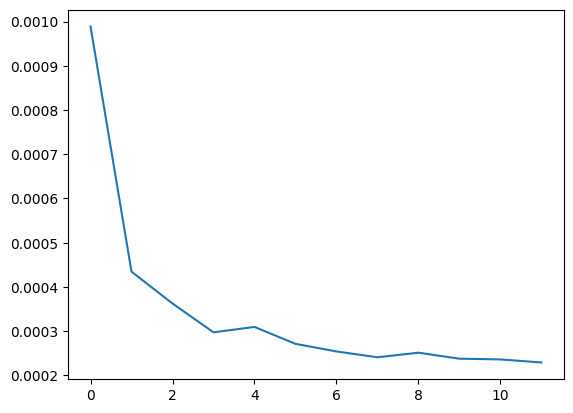

In [229]:
loss_per_epoch = LSTM_model_with_Pos_vk_ru_bert.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [230]:
first_eval_batch = generator[-n_input-1][0]
current_batch = first_eval_batch.reshape((1, n_input, n_features))


In [231]:
test_predictions_30 = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_with_Pos_vk_ru_bert.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions_30.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],  [[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['vk_posotive_rubert'].iloc[i] , test_for_LSTM['vk_negative_rubert'].iloc[i]]) ]]      ,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

In [232]:
test_for_LSTM = merged_df_VK_ruBert.iloc[-n_input:]
true_predictions = scaler.inverse_transform(test_predictions_30)
test_for_LSTM['Predictions'] = true_predictions


C:\Users\User\AppData\Local\Temp\ipykernel_22260\1659395672.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['Predictions'] = true_predictions


<Axes: xlabel='date'>

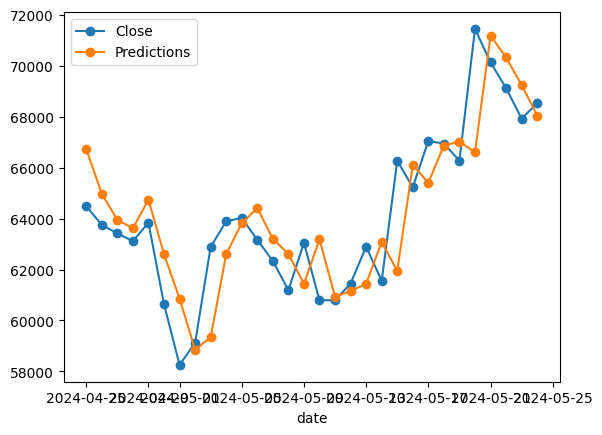

In [233]:
columns_to_plot = ['Close', 'Predictions']
test_for_LSTM[columns_to_plot].plot(marker='o', label = True)

In [234]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}")

# Root Mean squared error: 1832.2640250867648
# Mean squared error: 3357191.4576271526
# SMAPE: 2.2247511694211597

# Root Mean squared error: 1803.5454506536717
# Mean squared error: 3420818.3740336937
# SMAPE: 2.0226404255035923

Root Mean squared error: 1832.2640250867648
Mean squared error: 3357191.4576271526
SMAPE: 2.2247511694211597


# Попробою объеденить ВК и РБК на РУ берте

In [290]:
merged_df_VK_ruBert

,Close,vk_posotive_rubert,vk_negative_rubert
date,,,
2014-09-17,457.334015,-1.000000,-1.000000
2014-09-18,424.440002,-1.000000,-1.000000
2014-09-19,394.795990,-1.000000,-1.000000
2014-09-20,408.903992,-1.000000,-1.000000
2014-09-21,398.821014,-1.000000,-1.000000
...,...,...,...
2024-05-20,71448.195312,0.587997,0.412003
2024-05-21,70136.531250,0.500050,0.499950
2024-05-22,69122.335938,0.440496,0.559504


In [291]:
rbk_RuBeart_Titles_Sentiment

,publish_date,rbk_positive,rbk_negative
0,2017-12-08,0.508701,0.491299
1,2018-02-07,0.368749,0.631251
2,2018-02-26,0.459262,0.540738
3,2018-02-28,0.490551,0.509449
4,2018-03-01,0.347643,0.652357
...,...,...,...
1921,2024-05-20,0.404926,0.595074
1922,2024-05-21,0.412522,0.587478
1923,2024-05-22,0.482541,0.517459
1924,2024-05-23,0.366537,0.633463


In [292]:
merged_df_VK_and_RBK_ruBert = pd.merge(merged_df_VK_ruBert, rbk_RuBeart_Titles_Sentiment, how='left', left_index=True, right_on='publish_date')
#merged_df_VK_and_RBK_ruBert.drop(columns=['publish_date'], inplace=True)

In [293]:
# Шаг 3: Замаскировать пропуски в данных rbk_RuBeart_Titles_Sentiment
merged_df_VK_and_RBK_ruBert['rbk_positive'] = np.ma.masked_invalid(merged_df_VK_and_RBK_ruBert['rbk_positive'])
merged_df_VK_and_RBK_ruBert['rbk_negative'] = np.ma.masked_invalid(merged_df_VK_and_RBK_ruBert['rbk_negative'])

# Замена маскированных значений на -1
merged_df_VK_and_RBK_ruBert['rbk_positive'] = merged_df_VK_and_RBK_ruBert['rbk_positive'].fillna(np.float64(-1))
merged_df_VK_and_RBK_ruBert['rbk_negative'] = merged_df_VK_and_RBK_ruBert['rbk_negative'].fillna(np.float64(-1))

In [295]:
merged_df_VK_and_RBK_ruBert = merged_df_VK_and_RBK_ruBert.set_index('publish_date')

In [296]:
merged_df_VK_and_RBK_ruBert

,Close,vk_posotive_rubert,vk_negative_rubert,rbk_positive,rbk_negative
publish_date,,,,,
2014-09-17,457.334015,-1.000000,-1.000000,-1.000000,-1.000000
2014-09-18,424.440002,-1.000000,-1.000000,-1.000000,-1.000000
2014-09-19,394.795990,-1.000000,-1.000000,-1.000000,-1.000000
2014-09-20,408.903992,-1.000000,-1.000000,-1.000000,-1.000000
2014-09-21,398.821014,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...
2024-05-20,71448.195312,0.587997,0.412003,0.404926,0.595074
2024-05-21,70136.531250,0.500050,0.499950,0.412522,0.587478
2024-05-22,69122.335938,0.440496,0.559504,0.482541,0.517459



# Данные почти готовы

In [302]:
n_input = 30
train_for_LSTM = merged_df_VK_and_RBK_ruBert.iloc[:-n_input]
test_for_LSTM = merged_df_VK_and_RBK_ruBert.iloc[-n_input:]

In [303]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_train_for_LSTM = scaler.transform(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_test_for_LSTM = scaler.transform(test_for_LSTM['Close'].values.reshape(-1, 1))

dataset = hstack((scaled_train_for_LSTM, train_for_LSTM['vk_posotive_rubert'].values.reshape((-1, 1)), train_for_LSTM['vk_negative_rubert'].values.reshape((-1, 1)), train_for_LSTM['rbk_positive'].values.reshape((-1, 1)), train_for_LSTM['rbk_negative'].values.reshape((-1, 1))))

generator = TimeseriesGenerator(dataset, scaled_train_for_LSTM, length=n_input, batch_size=1)
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-0.99233991 -1.         -1.         -1.         -1.         -0.99324228
 -1.         -1.         -1.         -1.         -0.9940555  -1.
 -1.         -1.         -1.         -0.99366848 -1.         -1.
 -1.         -1.         -0.99394508 -1.         -1.         -1.
 -1.         -0.99385371 -1.         -1.         -1.         -1.
 -0.99293089 -1.         -1.         -1.         -1.         -0.99327616
 -1.         -1.         -1.         -1.         -0.99359523 -1.
 -1.         -1.         -1.         -0.99379135 -1.         -1.
 -1.         -1.         -0.99392591 -1.         -1.         -1.
 -1.         -0.99453873 -1.         -1.         -1.         -1.
 -0.99458575 -1.         -1.         -1.         -1.         -0.9942709
 -1.         -1.         -1.         -1.         -0.99436223 -1.
 -1.         -1.         -1.         -0.99459659 -1.         -1.
 -1.         -1.         -0.99502344 -1.         -1.         -1.
 -1.         -0.99586415 -1.         -1.         

In [304]:
n_features = X.shape[2]
n_features

5

In [ ]:
mask = np.float64(-1)
type(mask)

In [ ]:
best_random_seed_for_rubert_vk_and_rbk = 0
best_rmse_for_rubert_vk_and_rbk = 10000
for el in range(0,50):
    keras.utils.set_random_seed(el)
    LSTM_model_with_sent_vk_and_rbk_ru_bert = Sequential()
    LSTM_model_with_sent_vk_and_rbk_ru_bert.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
    LSTM_model_with_sent_vk_and_rbk_ru_bert.add(LSTM(100, input_shape=(n_input, n_features)))
    LSTM_model_with_sent_vk_and_rbk_ru_bert.add(Dense(6))
    LSTM_model_with_sent_vk_and_rbk_ru_bert.add(Dense(1))
    LSTM_model_with_sent_vk_and_rbk_ru_bert.compile(optimizer='adam', loss='mse')
    LSTM_model_with_sent_vk_and_rbk_ru_bert.fit(generator,epochs=12)


    first_eval_batch = generator[-n_input-1][0]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    test_predictions_30 = []
    for i in range(len(test_for_LSTM)):
        
        # get the prediction value for the first batch
        current_pred = LSTM_model_with_sent_vk_and_rbk_ru_bert.predict(current_batch)[0]
        current_pred = current_pred[-1:] 
        
        # append the prediction into the array
        test_predictions_30.append(current_pred) 
        
        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],  [[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['vk_posotive_rubert'].iloc[i] , test_for_LSTM['vk_negative_rubert'].iloc[i] , test_for_LSTM['rbk_positive'].iloc[i] , test_for_LSTM['rbk_negative'].iloc[i]  ]) ]]      ,axis=1)      
    
    test_for_LSTM = merged_df_VK_and_RBK_ruBert.iloc[-n_input:]

    true_predictions = scaler.inverse_transform(test_predictions_30)
    test_for_LSTM['Predictions'] = true_predictions

    rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))

    # best_rmse_for_rubert_vk_and_rbk: 2002.219074937116
    # best_random_seed_for_rubert_vk_and_rbk: 14
    if rmse < best_rmse_for_rubert_vk_and_rbk:
        best_rmse_for_rubert_vk_and_rbk = rmse
        best_random_seed_for_rubert_vk_and_rbk = el
    del LSTM_model_with_sent_vk_and_rbk_ru_bert

print("best_rmse_for_rubert_vk_and_rbk: " + str(best_rmse_for_rubert_vk_and_rbk))
print("best_random_seed_for_rubert_vk_and_rbk: " + str(best_random_seed_for_rubert_vk_and_rbk))

In [305]:
keras.utils.set_random_seed(best_random_seed_for_rubert_vk_and_rbk)
# define model
LSTM_model_with_sent_vk_and_rbk_ru_bert = Sequential()
LSTM_model_with_sent_vk_and_rbk_ru_bert.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
LSTM_model_with_sent_vk_and_rbk_ru_bert.add(LSTM(100, input_shape=(n_input, n_features)))
LSTM_model_with_sent_vk_and_rbk_ru_bert.add(Dense(6))
LSTM_model_with_sent_vk_and_rbk_ru_bert.add(Dense(1))
LSTM_model_with_sent_vk_and_rbk_ru_bert.compile(optimizer='adam', loss='mse')
LSTM_model_with_sent_vk_and_rbk_ru_bert.fit(generator,epochs=12)

Epoch 1/12


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  28/3478 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.2760   

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.0153
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0015
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0012
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 9.8877e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 9.1481e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 8.3887e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 8.5212e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 8.6083e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 8.6057e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 6.9162e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 7.9811e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 7.8876e-04


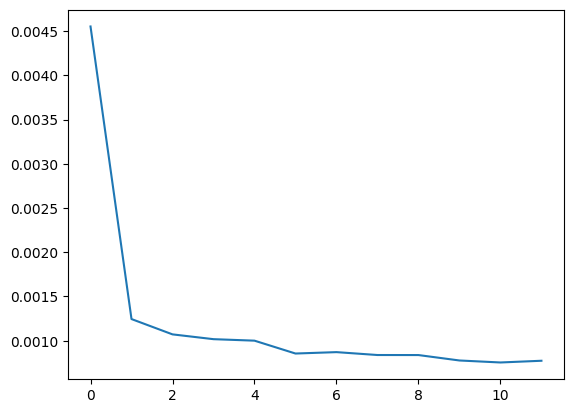

In [306]:
loss_per_epoch = LSTM_model_with_sent_vk_and_rbk_ru_bert.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [307]:

first_eval_batch = generator[-n_input-1][0]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [308]:
test_predictions_30 = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_with_sent_vk_and_rbk_ru_bert.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions_30.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],  [[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['vk_posotive_rubert'].iloc[i] , test_for_LSTM['vk_negative_rubert'].iloc[i] , test_for_LSTM['rbk_positive'].iloc[i] , test_for_LSTM['rbk_negative'].iloc[i]  ]) ]]      ,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━

In [309]:
true_predictions = scaler.inverse_transform(test_predictions_30)
test_for_LSTM['Predictions'] = true_predictions

C:\Users\User\AppData\Local\Temp\ipykernel_22260\1492626813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['Predictions'] = true_predictions


<Axes: xlabel='publish_date'>

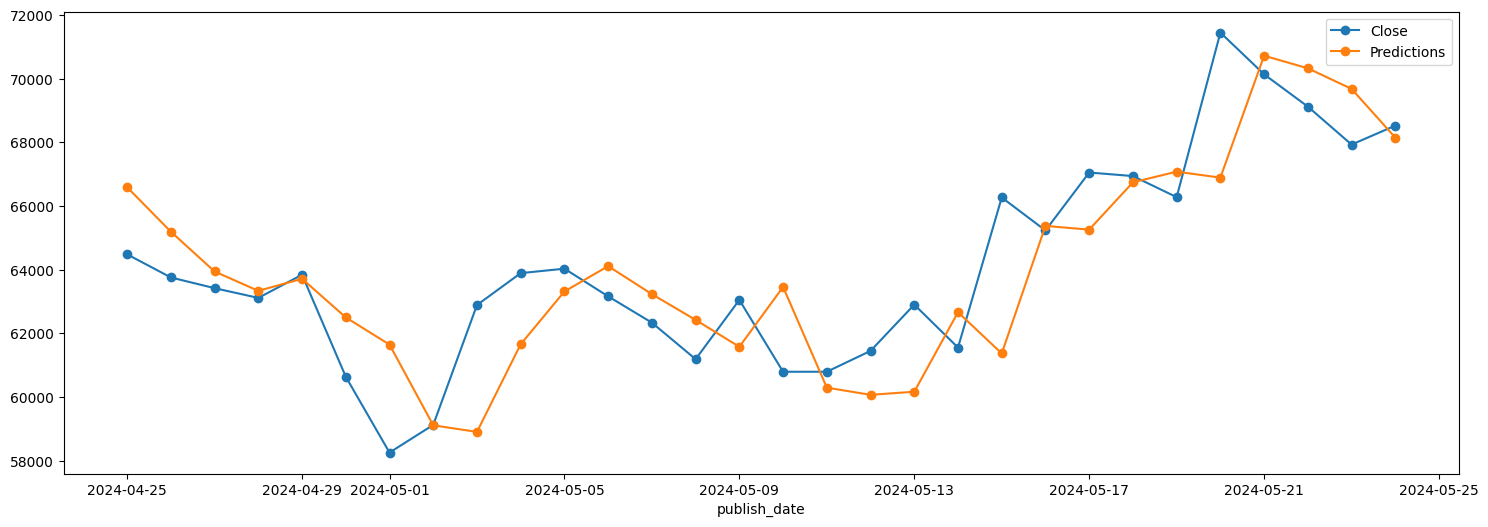

In [310]:
columns_to_plot = ['Close', 'Predictions']
test_for_LSTM[columns_to_plot].plot(figsize=(18,6), marker='o', label = True)

In [311]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}")

# Root Mean squared error: 2339.998508917034
# Mean squared error: 5475593.021733943
# SMAPE: 2.6806655375617585

Root Mean squared error: 2002.219074937116
Mean squared error: 4008881.22404204
SMAPE: 2.3998838642342735


# Попробую использовать CryptoBert для ВК

In [259]:
vk_data_from_CryptoBert = pd.read_csv('vk_CryptoBert_text_Sentiment.csv')

# Убедимся, что publish_date в формате datetime
vk_data_from_CryptoBert['publish_date'] = pd.to_datetime(vk_data_from_CryptoBert['publish_date'])
# Шаг 2: Агрегация значений по дням
vk_data_from_CryptoBert = vk_data_from_CryptoBert.groupby('publish_date').mean().reset_index()
# Преобразование publish_date в дату без времени
vk_data_from_CryptoBert['publish_date'] = vk_data_from_CryptoBert['publish_date'].apply(lambda x: x.date())

# Объединение данных
merged_df_VK_CryptoBert = pd.merge(my_df, vk_data_from_CryptoBert, how='left', left_on='date', right_on='publish_date')
merged_df_VK_CryptoBert.set_index('date', inplace=True)
merged_df_VK_CryptoBert.drop(columns=['publish_date'], inplace=True)
merged_df_VK_CryptoBert
# Шаг 3: Замаскировать пропуски в данных rbk_RuBeart_Titles_Sentiment
merged_df_VK_CryptoBert['vk_postive_cryptobert'] = np.ma.masked_invalid(merged_df_VK_CryptoBert['vk_postive_cryptobert'])
merged_df_VK_CryptoBert['vk_negative_cryptobert'] = np.ma.masked_invalid(merged_df_VK_CryptoBert['vk_negative_cryptobert'])
merged_df_VK_CryptoBert['vk_neutral_cryptobert'] = np.ma.masked_invalid(merged_df_VK_CryptoBert['vk_neutral_cryptobert'])

# Замена маскированных значений на -1
merged_df_VK_CryptoBert['vk_postive_cryptobert'] = merged_df_VK_CryptoBert['vk_postive_cryptobert'].fillna(np.float64(-1))
merged_df_VK_CryptoBert['vk_negative_cryptobert'] = merged_df_VK_CryptoBert['vk_negative_cryptobert'].fillna(np.float64(-1))
merged_df_VK_CryptoBert['vk_neutral_cryptobert'] = merged_df_VK_CryptoBert['vk_neutral_cryptobert'].fillna(np.float64(-1))

# Данные почти готовы

In [260]:
n_input = 30
train_for_LSTM = merged_df_VK_CryptoBert.iloc[:-n_input]
test_for_LSTM = merged_df_VK_CryptoBert.iloc[-n_input:]
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_train_for_LSTM = scaler.transform(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_test_for_LSTM = scaler.transform(test_for_LSTM['Close'].values.reshape(-1, 1))

In [261]:
dataset = hstack((scaled_train_for_LSTM, train_for_LSTM['vk_postive_cryptobert'].values.reshape((-1, 1)), train_for_LSTM['vk_negative_cryptobert'].values.reshape((-1, 1)), train_for_LSTM['vk_neutral_cryptobert'].values.reshape((-1, 1))))

In [262]:
generator = TimeseriesGenerator(dataset, scaled_train_for_LSTM, length=n_input, batch_size=1)
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')
n_features = X.shape[2]
n_features

Given the Array: 
[ 0.00383005 -1.         -1.         -1.          0.00337886 -1.
 -1.         -1.          0.00297225 -1.         -1.         -1.
  0.00316576 -1.         -1.         -1.          0.00302746 -1.
 -1.         -1.          0.00307315 -1.         -1.         -1.
  0.00353455 -1.         -1.         -1.          0.00336192 -1.
 -1.         -1.          0.00320238 -1.         -1.         -1.
  0.00310432 -1.         -1.         -1.          0.00303705 -1.
 -1.         -1.          0.00273063 -1.         -1.         -1.
  0.00270712 -1.         -1.         -1.          0.00286455 -1.
 -1.         -1.          0.00281889 -1.         -1.         -1.
  0.00270171 -1.         -1.         -1.          0.00248828 -1.
 -1.         -1.          0.00206793 -1.         -1.         -1.
  0.00195331 -1.         -1.         -1.          0.00208456 -1.
 -1.         -1.          0.00216834 -1.         -1.         -1.
  0.00239814 -1.         -1.         -1.          0.00256391 -1.
 -1.   

4

In [263]:
type(X[0][1][1])

numpy.float64

In [264]:
mask = np.float64(-1)
type(mask)

numpy.float64

In [ ]:
best_random_seed_for_crypto_bert_vk = 0
best_rmse_for_crypto_bert_vk_and_rbk = 10000
for el in range(0,50):
    keras.utils.set_random_seed(el)
    LSTM_model_with_Pos_vk_Crypto_bert = Sequential()
    LSTM_model_with_Pos_vk_Crypto_bert.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
    LSTM_model_with_Pos_vk_Crypto_bert.add(LSTM(100, input_shape=(n_input, n_features)))
    LSTM_model_with_Pos_vk_Crypto_bert.add(Dense(6))
    LSTM_model_with_Pos_vk_Crypto_bert.add(Dense(1))
    LSTM_model_with_Pos_vk_Crypto_bert.compile(optimizer='adam', loss='mse')
    LSTM_model_with_Pos_vk_Crypto_bert.fit(generator,epochs=12)


    first_eval_batch = generator[-n_input-1][0]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))
    test_predictions_30 = []

    for i in range(len(test_for_LSTM)):
        
        # get the prediction value for the first batch
        current_pred = LSTM_model_with_Pos_vk_Crypto_bert.predict(current_batch)[0]
        current_pred = current_pred[-1:] 
        
        # append the prediction into the array
        test_predictions_30.append(current_pred) 
        
        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],  [[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['vk_postive_cryptobert'].iloc[i] , test_for_LSTM['vk_negative_cryptobert'].iloc[i], test_for_LSTM['vk_neutral_cryptobert'].iloc[i]]) ]]      ,axis=1)

    test_for_LSTM = merged_df_VK_CryptoBert.iloc[-n_input:]

    true_predictions = scaler.inverse_transform(test_predictions_30)
    test_for_LSTM['Predictions'] = true_predictions

    rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))

    # best_rmse_for_crypto_bert_vk_and_rbk: 1848.3452591028138
    # best_random_seed_for_crypto_bert_vk: 12
    if rmse < best_rmse_for_crypto_bert_vk_and_rbk:
        best_rmse_for_crypto_bert_vk_and_rbk = rmse
        best_random_seed_for_crypto_bert_vk = el
    del LSTM_model_with_Pos_vk_Crypto_bert

print("best_rmse_for_crypto_bert_vk_and_rbk: " + str(best_rmse_for_crypto_bert_vk_and_rbk))
print("best_random_seed_for_crypto_bert_vk: " + str(best_random_seed_for_crypto_bert_vk))

In [267]:
keras.utils.set_random_seed(best_random_seed_for_crypto_bert_vk)
# define model
LSTM_model_with_Pos_vk_Crypto_bert = Sequential()
LSTM_model_with_Pos_vk_Crypto_bert.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
LSTM_model_with_Pos_vk_Crypto_bert.add(LSTM(100, input_shape=(n_input, n_features)))
LSTM_model_with_Pos_vk_Crypto_bert.add(Dense(6))
LSTM_model_with_Pos_vk_Crypto_bert.add(Dense(1))
LSTM_model_with_Pos_vk_Crypto_bert.compile(optimizer='adam', loss='mse')
LSTM_model_with_Pos_vk_Crypto_bert.fit(generator,epochs=12)

Epoch 1/12


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.0033
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 4.9150e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 3.8628e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.8341e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 3.6281e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.7657e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.7194e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.2884e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.5630e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.0765e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.3724e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 1.9849e-04


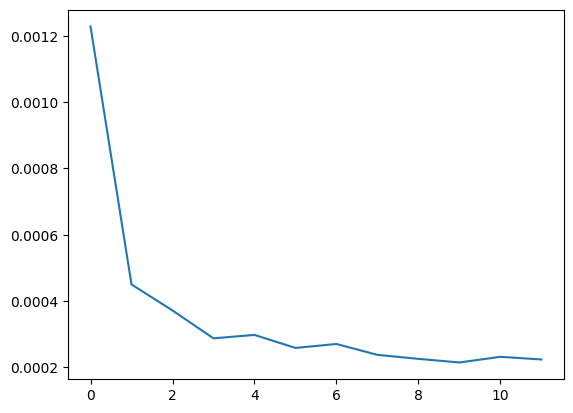

In [268]:
loss_per_epoch = LSTM_model_with_Pos_vk_Crypto_bert.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\4035329600.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['Predictions'] = true_predictions


<Axes: xlabel='date'>

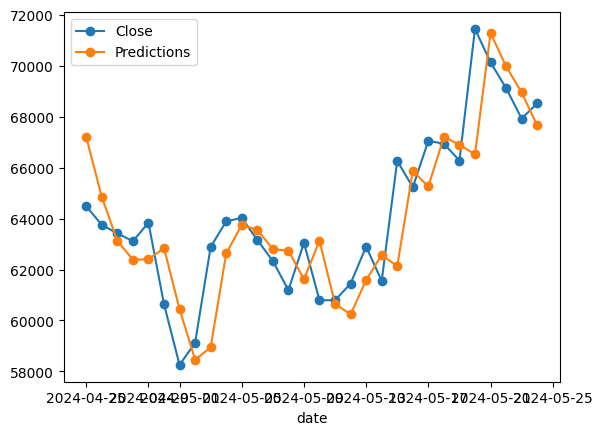

In [269]:
first_eval_batch = generator[-n_input-1][0]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
test_predictions_30 = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_with_Pos_vk_Crypto_bert.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions_30.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],  [[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['vk_postive_cryptobert'].iloc[i] , test_for_LSTM['vk_negative_cryptobert'].iloc[i], test_for_LSTM['vk_neutral_cryptobert'].iloc[i]]) ]]      ,axis=1)

true_predictions = scaler.inverse_transform(test_predictions_30)
test_for_LSTM['Predictions'] = true_predictions

columns_to_plot = ['Close', 'Predictions']
test_for_LSTM[columns_to_plot].plot(marker='o', label = True)


In [270]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}")

# Root Mean squared error: 1848.3452591028138
# Mean squared error: 3416380.196847848
# SMAPE: 2.239095908901343

Root Mean squared error: 1848.3452591028138
Mean squared error: 3416380.196847848
SMAPE: 2.239095908901343


# CRYPTO_BERT + VK + RBK

In [313]:
merged_df_VK_and_RBK_cryptoBert = pd.merge(merged_df_VK_CryptoBert, rbk_data_from_cryptobert, how='left', left_index=True, right_on='publish_date')
#merged_df_VK_and_RBK_cryptoBert.drop(columns=['publish_date'], inplace=True)

# Шаг 3: Замаскировать пропуски в данных rbk_data_from_cryptobert
merged_df_VK_and_RBK_cryptoBert['rbk_postive_cryptobert'] = np.ma.masked_invalid(merged_df_VK_and_RBK_cryptoBert['rbk_postive_cryptobert'])
merged_df_VK_and_RBK_cryptoBert['rbk_negative_cryptobert'] = np.ma.masked_invalid(merged_df_VK_and_RBK_cryptoBert['rbk_negative_cryptobert'])
merged_df_VK_and_RBK_cryptoBert['rbk_neutral_cryptobert'] = np.ma.masked_invalid(merged_df_VK_and_RBK_cryptoBert['rbk_neutral_cryptobert'])

# Замена маскированных значений на -1
merged_df_VK_and_RBK_cryptoBert['rbk_postive_cryptobert'] = merged_df_VK_and_RBK_cryptoBert['rbk_postive_cryptobert'].fillna(np.float64(-1))
merged_df_VK_and_RBK_cryptoBert['rbk_negative_cryptobert'] = merged_df_VK_and_RBK_cryptoBert['rbk_negative_cryptobert'].fillna(np.float64(-1))
merged_df_VK_and_RBK_cryptoBert['rbk_neutral_cryptobert'] = merged_df_VK_and_RBK_cryptoBert['rbk_neutral_cryptobert'].fillna(np.float64(-1))

merged_df_VK_and_RBK_cryptoBert = merged_df_VK_and_RBK_cryptoBert.set_index('publish_date')

merged_df_VK_and_RBK_cryptoBert

,Close,vk_postive_cryptobert,vk_negative_cryptobert,vk_neutral_cryptobert,rbk_postive_cryptobert,rbk_negative_cryptobert,rbk_neutral_cryptobert
publish_date,,,,,,,
2014-09-17,457.334015,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2014-09-18,424.440002,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2014-09-19,394.795990,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2014-09-20,408.903992,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2014-09-21,398.821014,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...
2024-05-20,71448.195312,0.317753,0.006173,0.676074,0.321901,0.227655,0.450444
2024-05-21,70136.531250,0.580601,0.002148,0.417251,0.502853,0.012236,0.484911
2024-05-22,69122.335938,0.499246,0.012884,0.487870,0.372676,0.040811,0.586513


# Данные почти готовы

In [320]:
n_input = 30
train_for_LSTM = merged_df_VK_and_RBK_cryptoBert.iloc[:-n_input]
test_for_LSTM = merged_df_VK_and_RBK_cryptoBert.iloc[-n_input:]

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_train_for_LSTM = scaler.transform(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_test_for_LSTM = scaler.transform(test_for_LSTM['Close'].values.reshape(-1, 1))

In [315]:
dataset = hstack((scaled_train_for_LSTM, train_for_LSTM['vk_postive_cryptobert'].values.reshape((-1, 1)), train_for_LSTM['vk_negative_cryptobert'].values.reshape((-1, 1)), train_for_LSTM['vk_neutral_cryptobert'].values.reshape((-1, 1)), train_for_LSTM['rbk_postive_cryptobert'].values.reshape((-1, 1)), train_for_LSTM['rbk_negative_cryptobert'].values.reshape((-1, 1)), train_for_LSTM['rbk_neutral_cryptobert'].values.reshape((-1, 1))))

In [316]:
generator = TimeseriesGenerator(dataset, scaled_train_for_LSTM, length=n_input, batch_size=1)
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-0.99233991 -1.         -1.         -1.         -1.         -1.
 -1.         -0.99324228 -1.         -1.         -1.         -1.
 -1.         -1.         -0.9940555  -1.         -1.         -1.
 -1.         -1.         -1.         -0.99366848 -1.         -1.
 -1.         -1.         -1.         -1.         -0.99394508 -1.
 -1.         -1.         -1.         -1.         -1.         -0.99385371
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.99293089 -1.         -1.         -1.         -1.         -1.
 -1.         -0.99327616 -1.         -1.         -1.         -1.
 -1.         -1.         -0.99359523 -1.         -1.         -1.
 -1.         -1.         -1.         -0.99379135 -1.         -1.
 -1.         -1.         -1.         -1.         -0.99392591 -1.
 -1.         -1.         -1.         -1.         -1.         -0.99453873
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.99458575 -1.         -1.         -1.         -1.    

In [317]:
n_features = X.shape[2]
n_features

7

In [318]:
mask = np.float64(-1)
type(mask)

numpy.float64

In [ ]:
best_random_seed_for_cryptobert_vk_and_rbk = 0
best_rmse_for_cryptobert_vk_and_rbk = 10000
for el in range(0,50):
    keras.utils.set_random_seed(el)
    LSTM_model_with_sent_vk_and_rbk_crypto_bert = Sequential()
    LSTM_model_with_sent_vk_and_rbk_crypto_bert.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
    LSTM_model_with_sent_vk_and_rbk_crypto_bert.add(LSTM(100, input_shape=(n_input, n_features)))
    LSTM_model_with_sent_vk_and_rbk_crypto_bert.add(Dense(6))
    LSTM_model_with_sent_vk_and_rbk_crypto_bert.add(Dense(1))
    LSTM_model_with_sent_vk_and_rbk_crypto_bert.compile(optimizer='adam', loss='mse')
    LSTM_model_with_sent_vk_and_rbk_crypto_bert.fit(generator,epochs=12)


    first_eval_batch = generator[-n_input-1][0]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    test_predictions_30 = []
    for i in range(len(test_for_LSTM)):
        
        # get the prediction value for the first batch
        current_pred = LSTM_model_with_sent_vk_and_rbk_crypto_bert.predict(current_batch)[0]
        current_pred = current_pred[-1:] 
        
        # append the prediction into the array
        test_predictions_30.append(current_pred) 
        
        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],  [[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['vk_postive_cryptobert'].iloc[i] , test_for_LSTM['vk_negative_cryptobert'].iloc[i], test_for_LSTM['vk_neutral_cryptobert'].iloc[i], test_for_LSTM['rbk_postive_cryptobert'].iloc[i] , test_for_LSTM['rbk_negative_cryptobert'].iloc[i], test_for_LSTM['rbk_neutral_cryptobert'].iloc[i]   ]) ]]      ,axis=1)      
    
    test_for_LSTM = merged_df_VK_and_RBK_cryptoBert.iloc[-n_input:]

    true_predictions = scaler.inverse_transform(test_predictions_30)
    test_for_LSTM['Predictions'] = true_predictions

    rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))

# best_rmse_for_cryptobert_vk_and_rbk: 2036.6019241551576
# best_random_seed_for_cryptobert_vk_and_rbk: 30
    if rmse < best_rmse_for_cryptobert_vk_and_rbk:
        best_rmse_for_cryptobert_vk_and_rbk = rmse
        best_random_seed_for_cryptobert_vk_and_rbk = el
    del LSTM_model_with_sent_vk_and_rbk_crypto_bert

print("best_rmse_for_cryptobert_vk_and_rbk: " + str(best_rmse_for_cryptobert_vk_and_rbk))
print("best_random_seed_for_cryptobert_vk_and_rbk: " + str(best_random_seed_for_cryptobert_vk_and_rbk))

Epoch 1/12


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.0120
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0013
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0013
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0010
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 8.5398e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 9.8834e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 8.0320e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 8.3263e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 8.7914e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 7.7121e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 7.9025e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 7.3228e-04


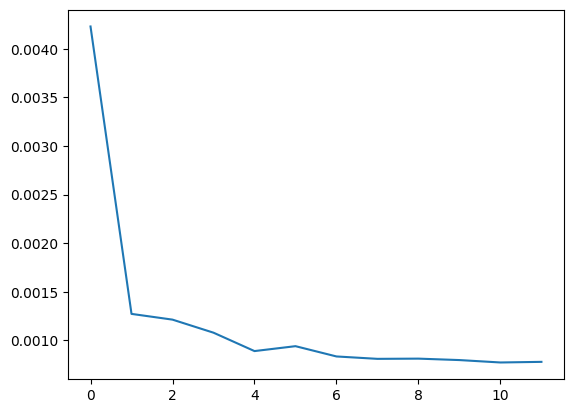

In [322]:

keras.utils.set_random_seed(best_random_seed_for_cryptobert_vk_and_rbk)
# define model
LSTM_model_with_sent_vk_and_rbk_crypto_bert = Sequential()
LSTM_model_with_sent_vk_and_rbk_crypto_bert.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
LSTM_model_with_sent_vk_and_rbk_crypto_bert.add(LSTM(100, input_shape=(n_input, n_features)))
LSTM_model_with_sent_vk_and_rbk_crypto_bert.add(Dense(6))
LSTM_model_with_sent_vk_and_rbk_crypto_bert.add(Dense(1))
LSTM_model_with_sent_vk_and_rbk_crypto_bert.compile(optimizer='adam', loss='mse')
LSTM_model_with_sent_vk_and_rbk_crypto_bert.fit(generator,epochs=12)
loss_per_epoch = LSTM_model_with_sent_vk_and_rbk_crypto_bert.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [323]:
first_eval_batch = generator[-n_input-1][0]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

test_predictions_30 = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_with_sent_vk_and_rbk_crypto_bert.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions_30.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],  [[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['vk_postive_cryptobert'].iloc[i] , test_for_LSTM['vk_negative_cryptobert'].iloc[i], test_for_LSTM['vk_neutral_cryptobert'].iloc[i], test_for_LSTM['rbk_postive_cryptobert'].iloc[i] , test_for_LSTM['rbk_negative_cryptobert'].iloc[i], test_for_LSTM['rbk_neutral_cryptobert'].iloc[i]   ]) ]]      ,axis=1)      

test_for_LSTM = merged_df_VK_and_RBK_cryptoBert.iloc[-n_input:]

true_predictions = scaler.inverse_transform(test_predictions_30)
test_for_LSTM['Predictions'] = true_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_22260\766156317.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['Predictions'] = true_predictions


In [324]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}")

# Root Mean squared error: 2339.998508917034
# Mean squared error: 5475593.021733943
# SMAPE: 2.6806655375617585

Root Mean squared error: 2036.6019241551576
Mean squared error: 4147747.39747249
SMAPE: 2.6067381043097564
